In [24]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from prophet import Prophet, plot, diagnostics

# Explore prophet for use with the s2s project

## Load data

In [25]:
def load_data_local(fname, var):
    with xr.open_dataset(fname) as ds:
        df = ds.to_dataframe()

    # Remove non-monotonic time-stamps
    # - find time diff > 2 days
    # - max in original dataset without problems of 2 days (leap year)
    ns_per_day = 86400000000000
    ndays = 2
    limit = ndays * ns_per_day
    if np.max(np.diff(df.index.values)) > limit:
        tmp_df = df.copy()
        while np.max(np.diff(tmp_df.index.values)) > limit:
            #print(np.max(np.diff(tmp_df.index.values)), np.argmax(np.diff(tmp_df.index.values)))
            drop_ix = np.argmax(np.diff(tmp_df.index.values)) + 1
            drop_time = tmp_df.iloc[drop_ix, :]
            new_df = tmp_df.drop(index=[drop_time.name])
            tmp_df = new_df
        df = tmp_df
    
    new_times = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
    new_df = df.reindex(index=new_times, columns=[var])
    new_df.fillna(method='ffill', inplace=True)
    
    return new_df

In [26]:
pabrc = load_data_local('../data/station-data/PABRC-ice_conc.nc', 'ICE_C_GDS0_SFC_ave6h')
weekly = pabrc.resample('W').mean()

## First models and lib evaluation

### Weekly data

In [27]:
weekly

ICE_C_GDS0_SFC_ave6h
2012-01-01              0.960000
2012-01-08              0.989714
2012-01-15              0.963429
2012-01-22              0.998571
2012-01-29              0.991714
...                          ...
2021-01-31              0.949857
2021-02-07              0.961429
2021-02-14              0.941286
2021-02-21              0.981571
2021-02-28              0.998714

[479 rows x 1 columns]

In [28]:
weekly_prophet = weekly.rename(columns={'ICE_C_GDS0_SFC_ave6h': 'y'})

In [29]:
weekly_prophet.reset_index(inplace=True)

In [30]:
weekly_prophet.rename(columns={'index': 'ds'}, inplace=True)

In [31]:
weekly_prophet

ds         y
0   2012-01-01  0.960000
1   2012-01-08  0.989714
2   2012-01-15  0.963429
3   2012-01-22  0.998571
4   2012-01-29  0.991714
..         ...       ...
474 2021-01-31  0.949857
475 2021-02-07  0.961429
476 2021-02-14  0.941286
477 2021-02-21  0.981571
478 2021-02-28  0.998714

[479 rows x 2 columns]

### Weekly - default

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -85.914
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       698.905   0.000304959       77.3222           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       698.938   0.000281443       67.2427   3.554e-06       0.001      184  LS failed, Hessian reset 
     150       698.953   3.48351e-08       69.4328       0.316           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


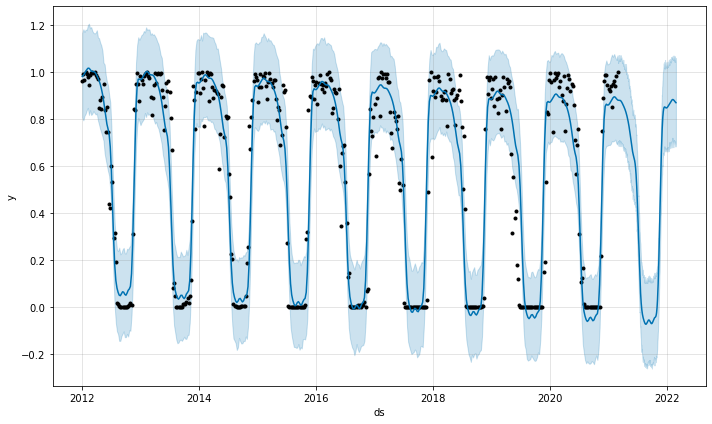

In [32]:
m = Prophet()
m.fit(weekly_prophet)

future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

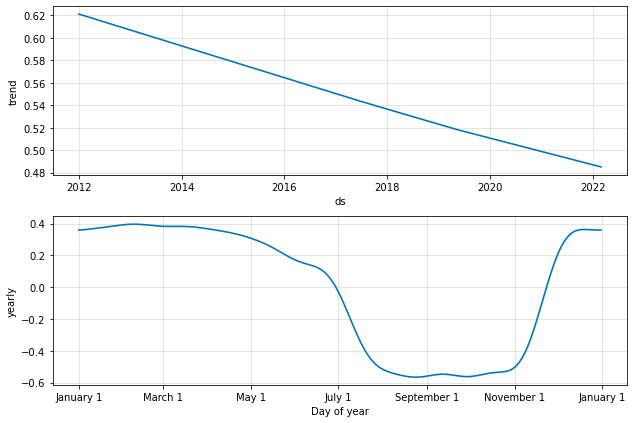

In [33]:
fig2 = m.plot_components(forecast)

### Weekly - capped

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       685.265    0.00291192       75.5767   3.634e-05       0.001      165  LS failed, Hessian reset 
      99       685.394   3.50996e-05        67.762      0.6845      0.6845      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       685.396   2.29418e-07       71.8675   3.161e-09       0.001      278  LS failed, Hessian reset 
     145       685.396   8.74886e-09        72.947     0.06851           1      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


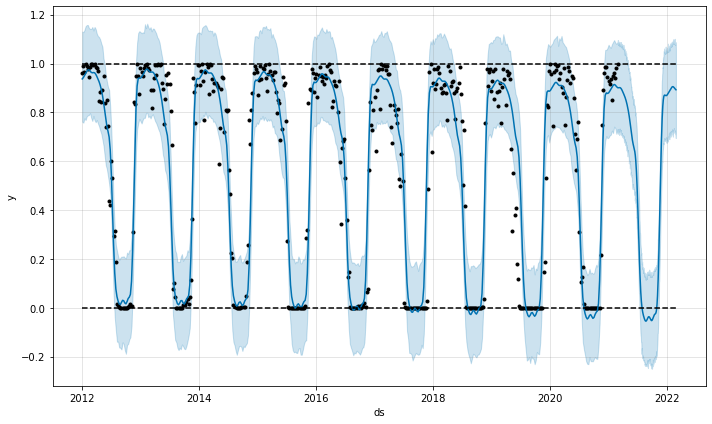

In [34]:
weekly_capped_prophet = weekly_prophet.copy()
weekly_capped_prophet['cap'] = 1.0
weekly_capped_prophet['floor'] = 0.0

m = Prophet(growth='logistic')
m.fit(weekly_capped_prophet)

future = m.make_future_dataframe(periods=365)
future['cap'] = 1.0
future['floor'] = 0.0

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

In [35]:
weekly = weekly_capped_prophet.copy()
weekly

ds         y  cap  floor
0   2012-01-01  0.960000  1.0    0.0
1   2012-01-08  0.989714  1.0    0.0
2   2012-01-15  0.963429  1.0    0.0
3   2012-01-22  0.998571  1.0    0.0
4   2012-01-29  0.991714  1.0    0.0
..         ...       ...  ...    ...
474 2021-01-31  0.949857  1.0    0.0
475 2021-02-07  0.961429  1.0    0.0
476 2021-02-14  0.941286  1.0    0.0
477 2021-02-21  0.981571  1.0    0.0
478 2021-02-28  0.998714  1.0    0.0

[479 rows x 4 columns]

### Daily Data

In [36]:
daily = pabrc

In [37]:
daily.reset_index(inplace=True)

In [38]:
daily

index  ICE_C_GDS0_SFC_ave6h
0    2012-01-01 06:00:00                 0.960
1    2012-01-02 06:00:00                 0.965
2    2012-01-03 06:00:00                 0.998
3    2012-01-04 06:00:00                 0.999
4    2012-01-05 06:00:00                 1.000
...                  ...                   ...
3342 2021-02-24 06:00:00                 0.996
3343 2021-02-25 06:00:00                 0.995
3344 2021-02-26 06:00:00                 1.000
3345 2021-02-27 06:00:00                 1.000
3346 2021-02-28 06:00:00                 1.000

[3347 rows x 2 columns]

In [39]:
daily.rename(columns={'index': 'ds', 'ICE_C_GDS0_SFC_ave6h': 'y'}, inplace=True)

In [23]:
daily

ds      y
0    2012-01-01 06:00:00  0.960
1    2012-01-02 06:00:00  0.965
2    2012-01-03 06:00:00  0.998
3    2012-01-04 06:00:00  0.999
4    2012-01-05 06:00:00  1.000
...                  ...    ...
3342 2021-02-24 06:00:00  0.996
3343 2021-02-25 06:00:00  0.995
3344 2021-02-26 06:00:00  1.000
3345 2021-02-27 06:00:00  1.000
3346 2021-02-28 06:00:00  1.000

[3347 rows x 2 columns]

In [40]:
daily['cap'] = 1
daily['floor'] = 0

In [41]:
m_daily = Prophet()
m_daily.fit(daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -598.614


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4572.63     0.0023395        119.39       1.019      0.1019      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4575.82   0.000869142       68.6108       0.395           1      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       4575.88   0.000526442       60.5569   6.856e-06       0.001      322  LS failed, Hessian reset 
     299       4576.02   2.50265e-05       86.6325      0.7559      0.7559      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4576.02   1.99406e-05       63.4988       1.367      0.3637      575   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     407       4576.02   3.91782e-06       62.7202      0.1732      0.7178      5

In [42]:
future = m_daily.make_future_dataframe(periods=365)
future.tail()

ds
3707 2022-02-24 06:00:00
3708 2022-02-25 06:00:00
3709 2022-02-26 06:00:00
3710 2022-02-27 06:00:00
3711 2022-02-28 06:00:00

In [43]:
future['cap'] = 1
future['floor'] = 0
future

ds  cap  floor
0    2012-01-01 06:00:00    1      0
1    2012-01-02 06:00:00    1      0
2    2012-01-03 06:00:00    1      0
3    2012-01-04 06:00:00    1      0
4    2012-01-05 06:00:00    1      0
...                  ...  ...    ...
3707 2022-02-24 06:00:00    1      0
3708 2022-02-25 06:00:00    1      0
3709 2022-02-26 06:00:00    1      0
3710 2022-02-27 06:00:00    1      0
3711 2022-02-28 06:00:00    1      0

[3712 rows x 3 columns]

In [44]:
forecast = m_daily.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
3707 2022-02-24 06:00:00  1.012570    0.810110    1.192948
3708 2022-02-25 06:00:00  1.010213    0.816525    1.222655
3709 2022-02-26 06:00:00  1.017001    0.805310    1.205379
3710 2022-02-27 06:00:00  1.016022    0.803119    1.212911
3711 2022-02-28 06:00:00  1.011789    0.822451    1.195564

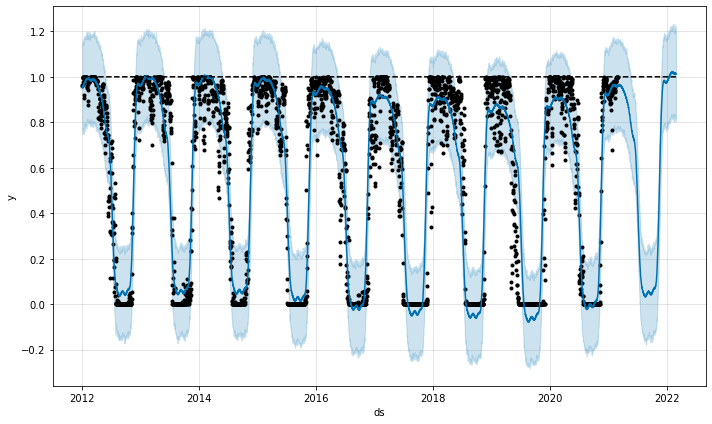

In [45]:
fig1 = m_daily.plot(forecast)

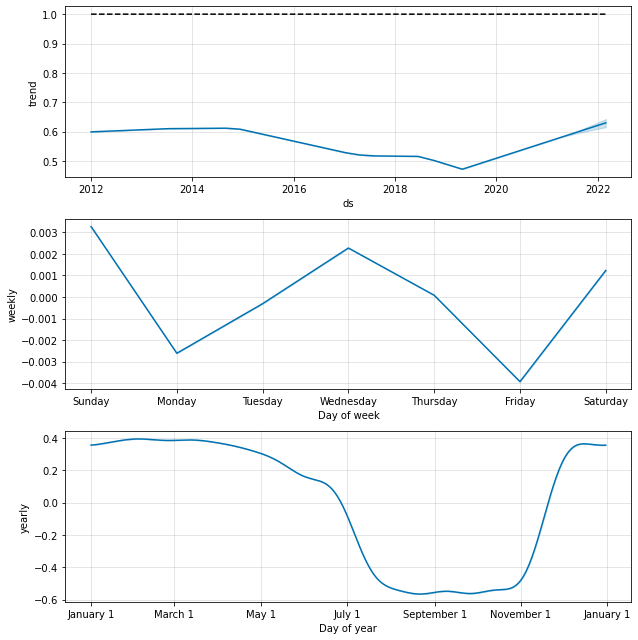

In [46]:
fig2 = m_daily.plot_components(forecast)

### Try with flat growth

In [47]:
m_flat_daily = Prophet(growth='flat')
m_flat_daily.fit(daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -306.99


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      10       4437.59   7.73202e-05      0.451361           1           1       15   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [48]:
future = m_flat_daily.make_future_dataframe(periods=365)
future.tail()

ds
3707 2022-02-24 06:00:00
3708 2022-02-25 06:00:00
3709 2022-02-26 06:00:00
3710 2022-02-27 06:00:00
3711 2022-02-28 06:00:00

In [49]:
future['cap'] = 1
future['floor'] = 0
future

ds  cap  floor
0    2012-01-01 06:00:00    1      0
1    2012-01-02 06:00:00    1      0
2    2012-01-03 06:00:00    1      0
3    2012-01-04 06:00:00    1      0
4    2012-01-05 06:00:00    1      0
...                  ...  ...    ...
3707 2022-02-24 06:00:00    1      0
3708 2022-02-25 06:00:00    1      0
3709 2022-02-26 06:00:00    1      0
3710 2022-02-27 06:00:00    1      0
3711 2022-02-28 06:00:00    1      0

[3712 rows x 3 columns]

In [50]:
forecast = m_flat_daily.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
3707 2022-02-24 06:00:00  0.942623    0.747421    1.146032
3708 2022-02-25 06:00:00  0.939993    0.730673    1.129127
3709 2022-02-26 06:00:00  0.946499    0.742766    1.143782
3710 2022-02-27 06:00:00  0.945320    0.725086    1.133876
3711 2022-02-28 06:00:00  0.940763    0.721873    1.154143

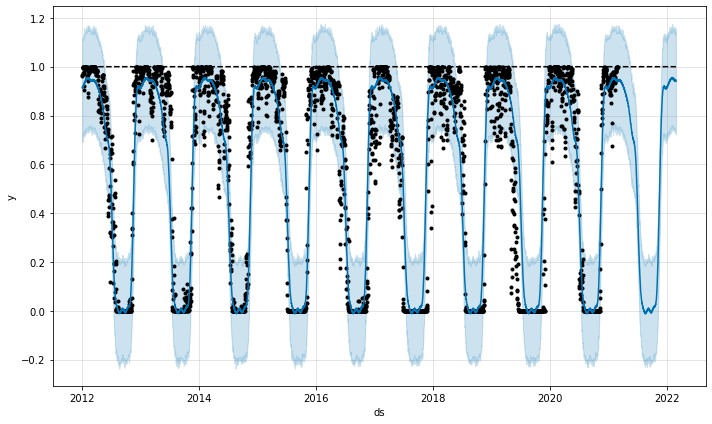

In [51]:
fig1 = m_flat_daily.plot(forecast)

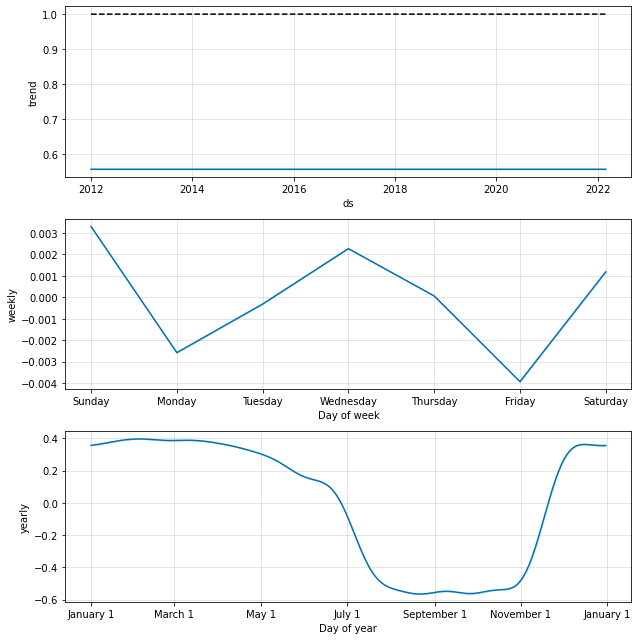

In [52]:
fig2 = m_flat_daily.plot_components(forecast)

### Try with no weekly component

In [53]:
m_daily_noweek = Prophet(weekly_seasonality=False)
m_daily_noweek.fit(daily)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -598.614


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4573.51     0.0119806       275.658          10           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4576.03   3.85585e-05       52.6561           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       4576.08    1.8614e-05       78.2997   2.275e-07       0.001      373  LS failed, Hessian reset 
     264       4576.08   3.23677e-07       45.4757       0.471       0.471      394   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [54]:
future = m_daily_noweek.make_future_dataframe(periods=365)
future.tail()

ds
3707 2022-02-24 06:00:00
3708 2022-02-25 06:00:00
3709 2022-02-26 06:00:00
3710 2022-02-27 06:00:00
3711 2022-02-28 06:00:00

In [55]:
future['cap'] = 1
future['floor'] = 0
future

ds  cap  floor
0    2012-01-01 06:00:00    1      0
1    2012-01-02 06:00:00    1      0
2    2012-01-03 06:00:00    1      0
3    2012-01-04 06:00:00    1      0
4    2012-01-05 06:00:00    1      0
...                  ...  ...    ...
3707 2022-02-24 06:00:00    1      0
3708 2022-02-25 06:00:00    1      0
3709 2022-02-26 06:00:00    1      0
3710 2022-02-27 06:00:00    1      0
3711 2022-02-28 06:00:00    1      0

[3712 rows x 3 columns]

In [56]:
forecast = m_daily_noweek.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
3707 2022-02-24 06:00:00  1.014429    0.814719    1.198196
3708 2022-02-25 06:00:00  1.014546    0.829380    1.224145
3709 2022-02-26 06:00:00  1.014744    0.825302    1.205152
3710 2022-02-27 06:00:00  1.015017    0.811975    1.204655
3711 2022-02-28 06:00:00  1.015356    0.809355    1.201867

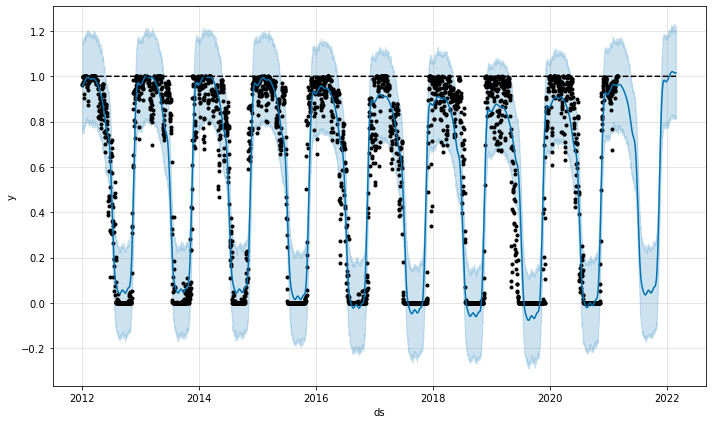

In [57]:
fig1 = m_daily_noweek.plot(forecast)

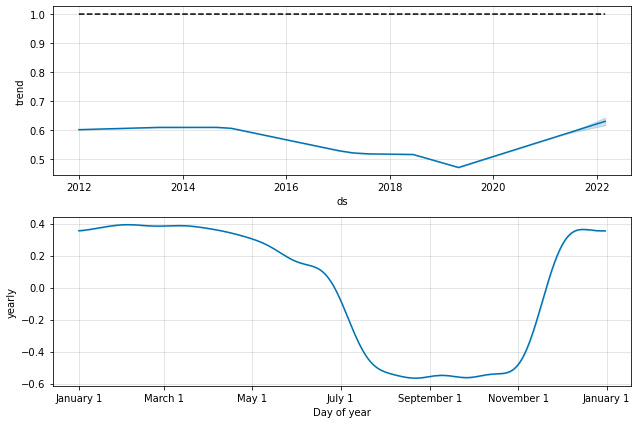

In [58]:
fig2 = m_daily_noweek.plot_components(forecast)

## Build ice-only models specifying args

In [59]:
%%html
<style>
table {float:left}
</style>

### Summary of RMSE metrics for horizon (forecast of 2020 when trained on 2012 - 2019)

| model | mean rmse | max rmse |
|-------|------|--------  |
| a | 0.270681 | 0.435618 |
| b | 0.151186 | 0.263871 |
| c | 0.139086 | 0.276647 |
| d | 0.116431 | 0.232883 |
| e | 0.118750 | 0.247361 |
| f | 0.114659 | 0.229446 |
| g | 0.139625 | 0.279165 |

### Key parameters for ice concentration only model

- growth = 'logistic'.  Ensures model saturates at 0 and 1 which is physicaly correct.
- seasonality_mode = 'multiplicative'. Combined with growth, ensures that trend + season is physically correct.
- Use weekly average values for training. Removes a lot of noise in the signal.
- Smaller effects: change_point = 0.9, n_changepoints=25

### Model A - Yearly seasonablity default check with daily values.

Data notes:
- Daily values with columns of cap and floor
- Forecast of daily values also with cap and floor

Notes:
- Many change points are missed.
- Trend seems wrong as well (I could check).

Initial log joint probability = -598.614
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4573.51     0.0119806       275.658          10           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4576.03   3.85585e-05       52.6561           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       4576.08    1.8614e-05       78.2997   2.275e-07       0.001      373  LS failed, Hessian reset 
     264       4576.08   3.23677e-07       45.4757       0.471       0.471      394   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -534.729
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3949.62     0.0302345       334.202      0.8145      0.81

Exception ignored in: <function tqdm.__del__ at 0x7f74a17dc940>
Traceback (most recent call last):
  File "/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


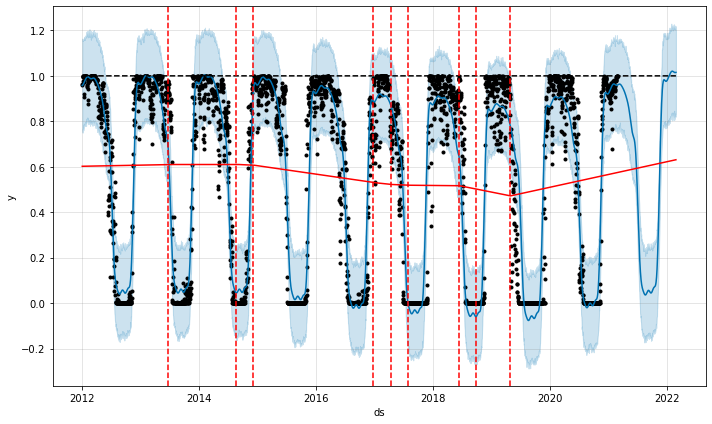

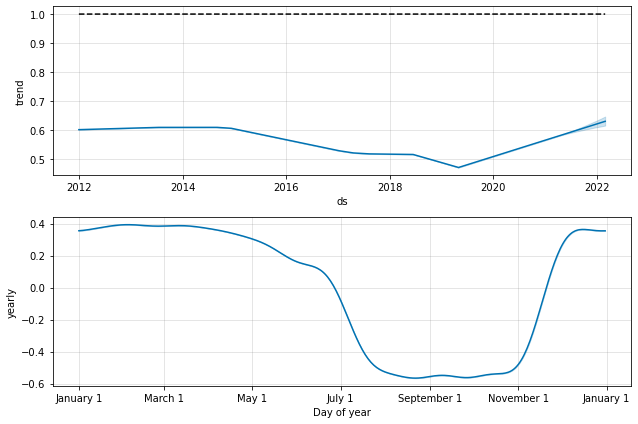

INFO:prophet:Skipping MAPE because y close to 0


count    330.000000
mean       0.269757
std        0.059772
min        0.179782
25%        0.231228
50%        0.250538
75%        0.311753
max        0.434467
Name: rmse, dtype: float64


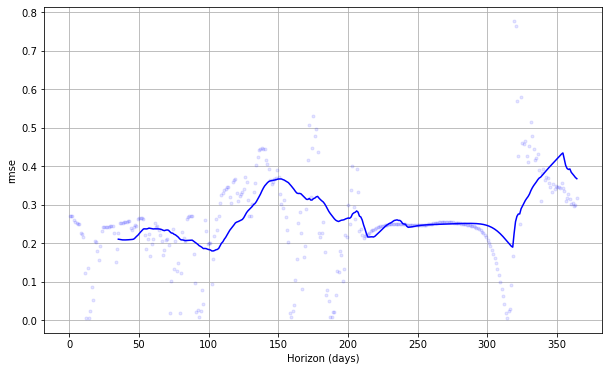

In [62]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive'
)
basic.fit(daily)
forecast = basic.predict(future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model B - Yearly seasonability default check with weekly values.

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed.
- Trend is better.
- Negative values

Initial log joint probability = -85.914
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       698.905   0.000304959       77.3222           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       698.938   0.000281443       67.2427   3.554e-06       0.001      184  LS failed, Hessian reset 
     150       698.953   3.48351e-08       69.4328       0.316           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


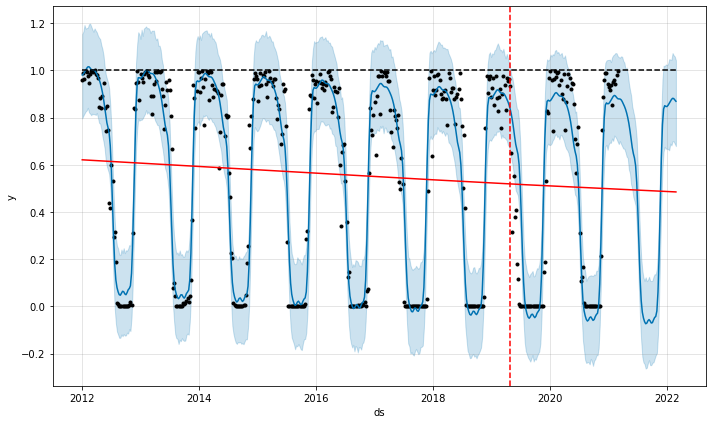

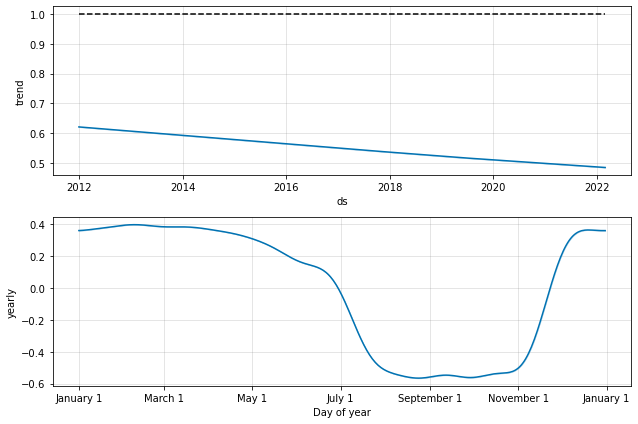

Initial log joint probability = -73.8944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      32       603.811    0.00098841       67.2781   2.034e-05       0.001       78  LS failed, Hessian reset 
      90       603.908   6.20361e-05       82.3588   8.496e-07       0.001      211  LS failed, Hessian reset 
      99       603.909   3.49764e-06       47.3291      0.3054           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126        603.91    1.2241e-06       47.3637   1.538e-08       0.001      299  LS failed, Hessian reset 
     137        603.91   9.50582e-09       63.8979     0.02737      0.5598      315   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.151188
std       0.052536
min       0.065178
25%       0.111721
50%       0.138384
75%       0.188060
max       0.263874
Name: rmse, dtype: float64


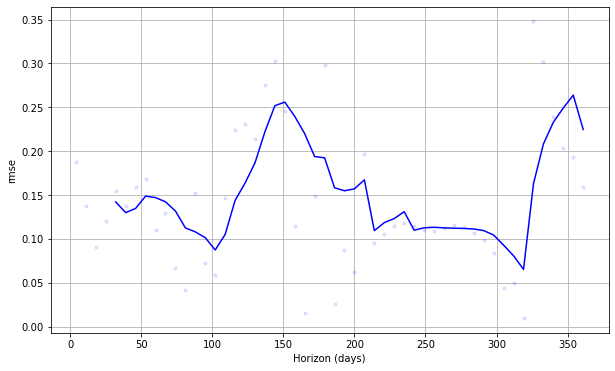

In [63]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive'
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)
plt.show()

cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model C - Yearly seasonablity default check with weekly values.

Model notes:
- Multiplicative seasonality

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed
- Trend is better
- Negative values

Initial log joint probability = -85.914
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       693.212    0.00024201       76.9294   3.201e-06       0.001      122  LS failed, Hessian reset 
      99       693.232   7.17729e-07       78.1795      0.2344           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       693.268    5.3815e-05       51.1069   8.723e-07       0.001      261  LS failed, Hessian reset 
     199       693.276   2.78548e-07       63.0452      0.3675      0.3675      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       693.291   3.85848e-07       75.3688      0.4614      0.4614      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       693.291   3.46222e-08        68.393      0.5908      0.5908      472   
Optimization terminate

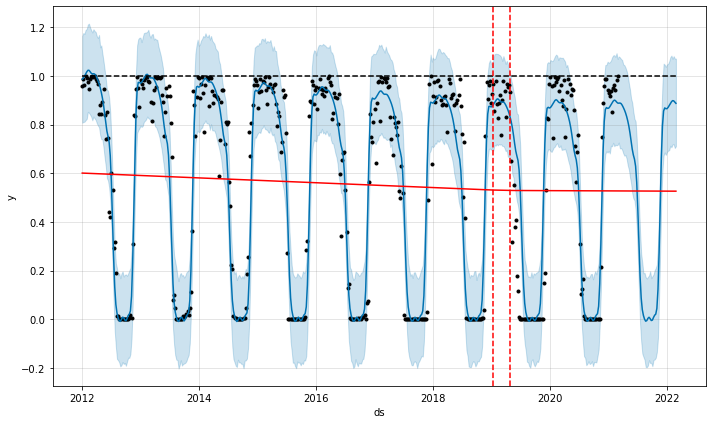

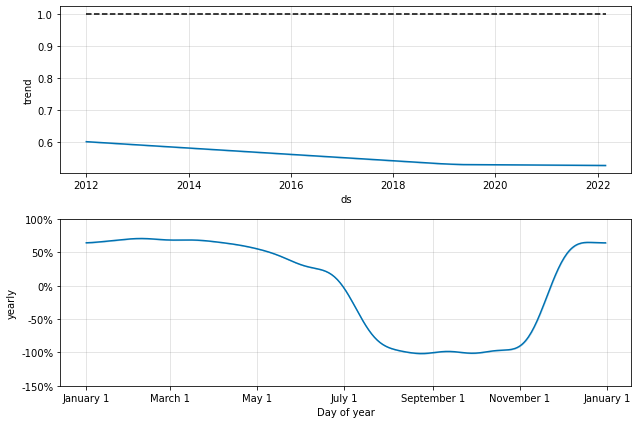

Initial log joint probability = -73.8944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       598.152   5.08812e-05       57.4785   7.507e-07       0.001      179  LS failed, Hessian reset 
      99       598.152    2.4107e-06        48.082      0.5634      0.5634      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       598.153   5.88876e-09       59.4641    0.007526      0.7312      235   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.139079
std       0.088294
min       0.002262
25%       0.063999
50%       0.157240
75%       0.193949
max       0.276637
Name: rmse, dtype: float64


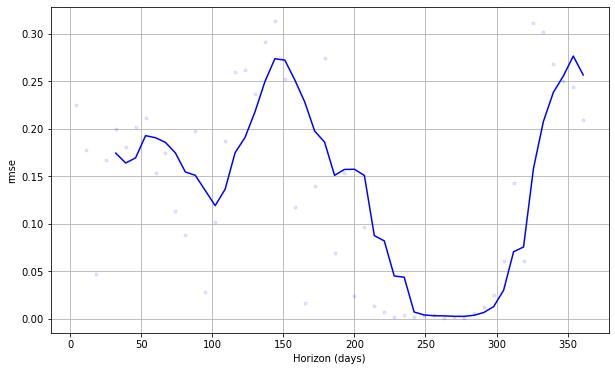

In [64]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative'
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()

cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model D - Yearly seasonablity, weekly values, logistic

Model notes:
- Multiplicative seasonality
- logistic model

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed, but much better in early part of time series. Need to explore.
- Trend is better
- Values remain sane, but misses the maximums

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        683.16   0.000827545       84.3009           1           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       683.185   0.000164374       87.7567   2.045e-06       0.001      201  LS failed, Hessian reset 
     129       683.194   8.90477e-09       65.5808      0.2868      0.2868      240   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


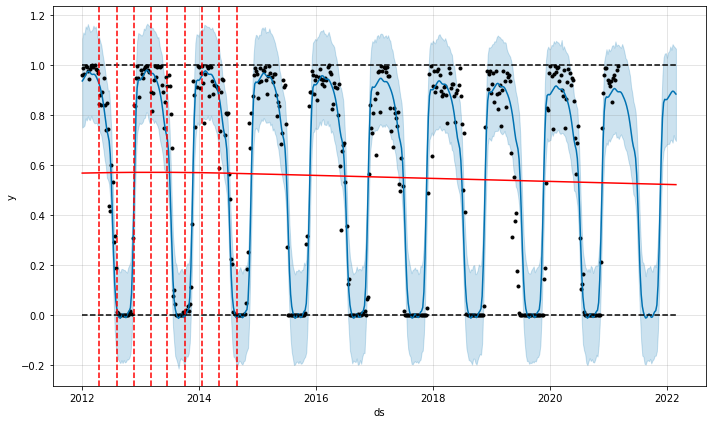

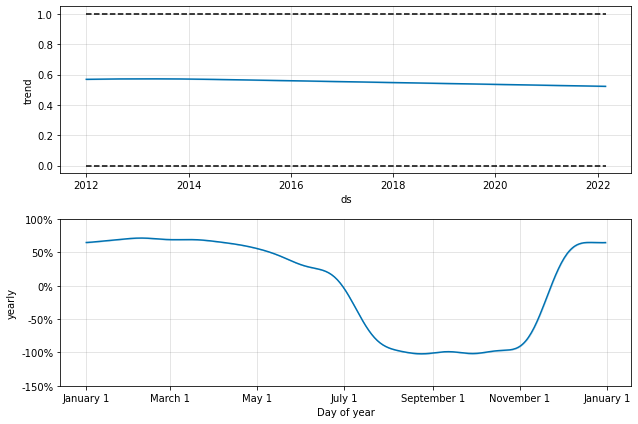

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       584.995   3.88364e-09       32.3813    0.006787           1      125   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.116431
std       0.072774
min       0.002344
25%       0.065947
50%       0.132201
75%       0.161057
max       0.232883
Name: rmse, dtype: float64


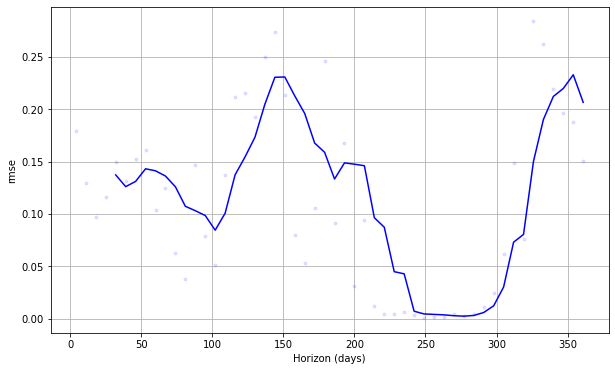

In [65]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative'
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()

cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model E - Yearly seasonablity, weekly values, logistic, add multi-annual seasonality

Model notes:
- Multiplicative seasonality
- logistic model
- tried 2, 3, 4 -annual seasonality with various Fourier orders and prior scales.

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed, but much better in early part of time series. Need to explore.
- Trend is better
- Annual and multi-iannual are more wavey due to Fourier terms. Not as ideal.


Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       734.254   0.000201993       73.7826   2.285e-06       0.001      163  LS failed, Hessian reset 
      99       734.263   1.85438e-07       72.2475      0.4045      0.4045      194   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       734.269   2.47522e-05       71.2749   3.219e-07       0.001      270  LS failed, Hessian reset 
     142        734.27   1.61564e-08       63.4867      0.3569      0.3569      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


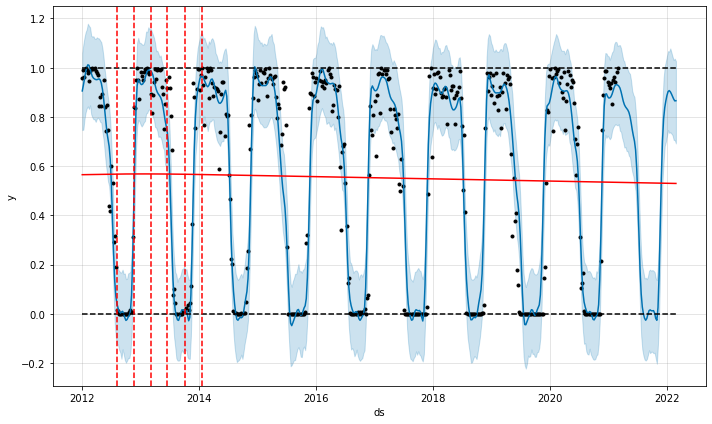

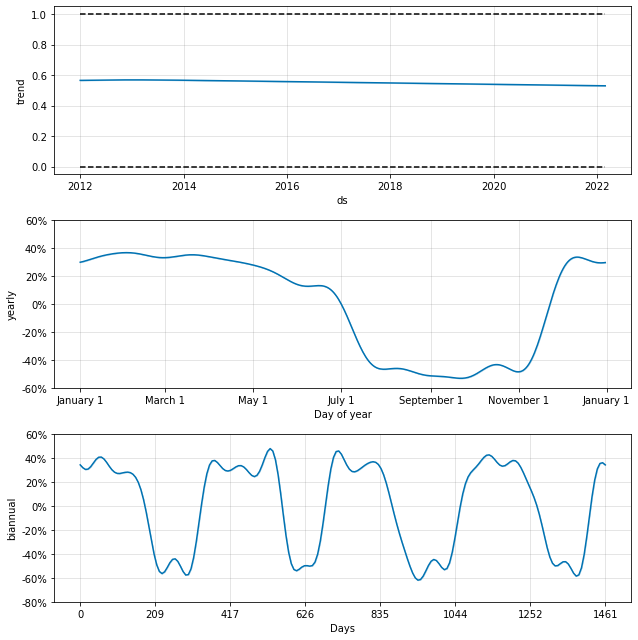

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41       631.018   6.92677e-06       55.2597   1.351e-07       0.001      104  LS failed, Hessian reset 
      72       631.177   0.000744672       39.2933   1.068e-05       0.001      203  LS failed, Hessian reset 
      99       631.207   5.30866e-06       69.8608      0.4241      0.4241      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109        631.21   6.15539e-05       67.6088   1.027e-06       0.001      315  LS failed, Hessian reset 
     135       631.212   1.03885e-06       47.0864   1.793e-08       0.001      396  LS failed, Hessian reset 
     150       631.212    9.8747e-09       64.7173      0.1658      0.1658      416   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.118657
std       0.074222
min       0.006965
25%       0.060750
50%       0.120833
75%       0.166187
max       0.247174
Name: rmse, dtype: float64


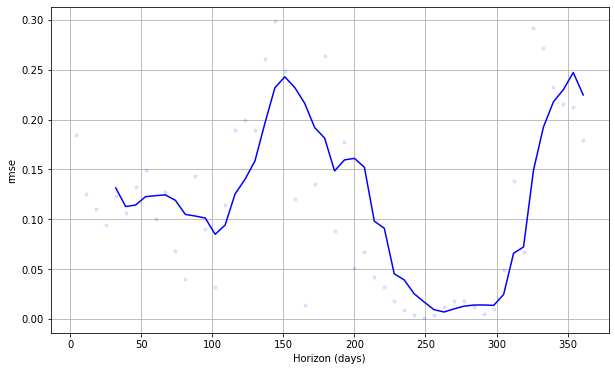

In [66]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative'
).add_seasonality(
    name='biannual',
    period = 365.25 * 4,
    fourier_order=20,  # total guess
    prior_scale=5
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model F - Yearly seasonablity, weekly values, logistic, change_point settings

Model notes:
- Multiplicative seasonality
- logistic model
- Increase percentage of training set used for traning: 0.8 -> 0.9

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed, but much better in early part of time series
- Trend is better
- More change points found and over all seems slightly improved

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       682.016   0.000538424       80.6946   6.852e-06       0.001      159  LS failed, Hessian reset 
      99       682.102   3.81163e-05       66.7641      0.2225           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       682.104   1.95232e-08       66.4784      0.1539      0.7041      220   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


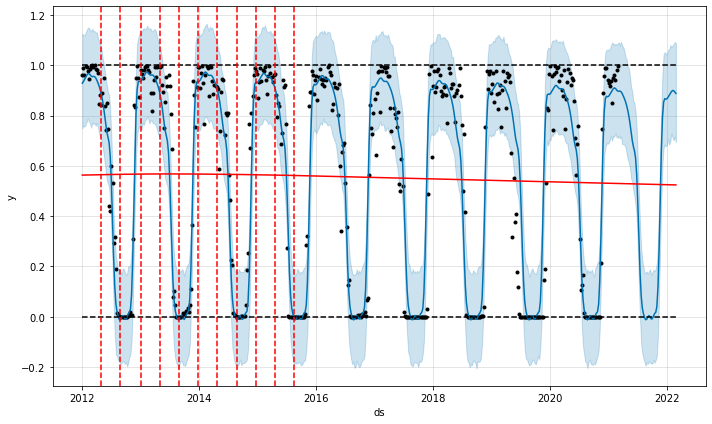

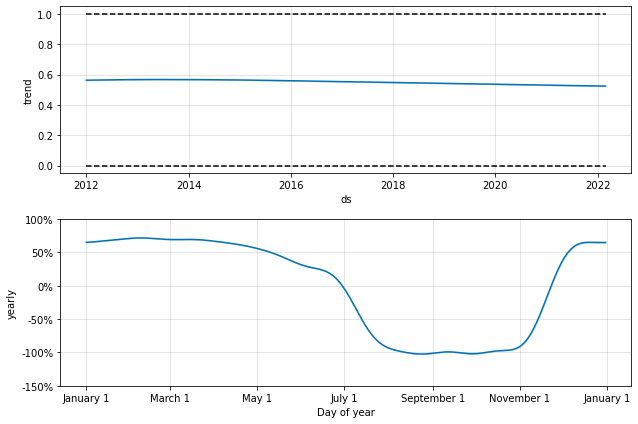

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       585.038   1.05424e-05       45.4667   1.458e-07       0.001      139  LS failed, Hessian reset 
      99       585.039   3.43131e-08       71.0254      0.1946      0.1946      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        585.04   1.19324e-05       63.2408    1.61e-07       0.001      238  LS failed, Hessian reset 
     131        585.04   2.02931e-07        64.263   3.094e-09       0.001      309  LS failed, Hessian reset 
     134        585.04   6.45156e-09       64.3699     0.04899           1      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.114650
std       0.071451
min       0.003493
25%       0.065463
50%       0.129878
75%       0.159107
max       0.229425
Name: rmse, dtype: float64


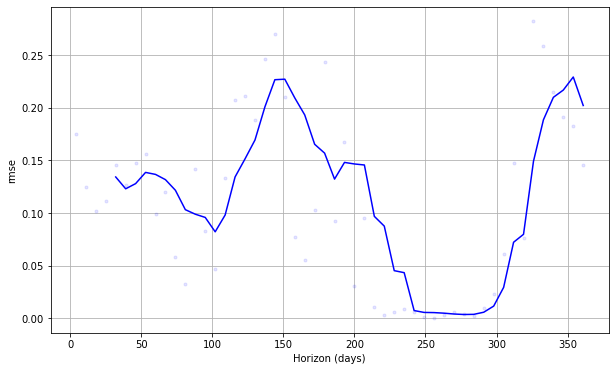

In [67]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       682.016   0.000538424       80.6946   6.852e-06       0.001      159  LS failed, Hessian reset 
      99       682.102   3.81163e-05       66.7641      0.2225           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       682.104   1.95232e-08       66.4784      0.1539      0.7041      220   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


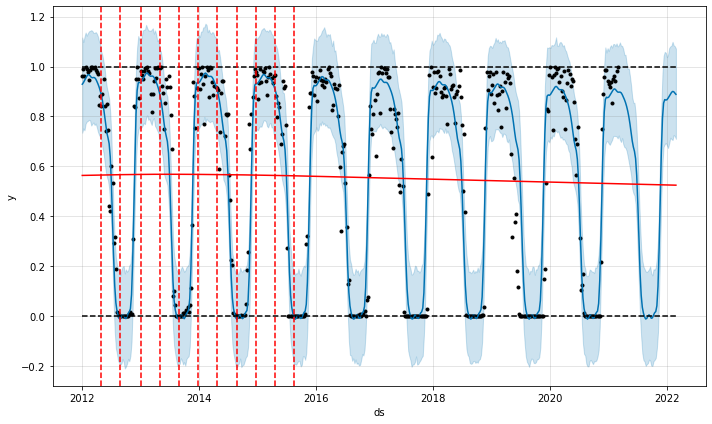

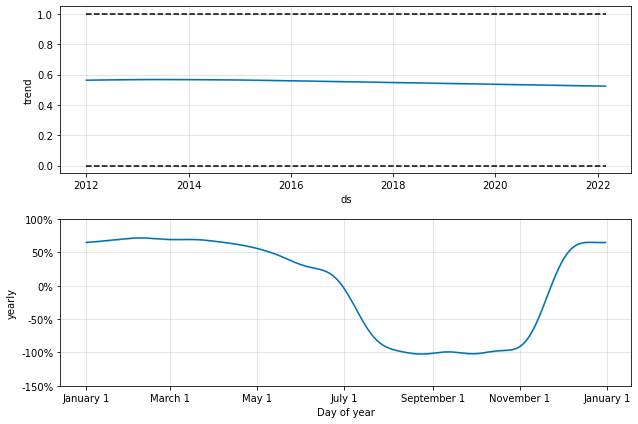

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       585.038   1.05424e-05       45.4667   1.458e-07       0.001      139  LS failed, Hessian reset 
      99       585.039   3.43131e-08       71.0254      0.1946      0.1946      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        585.04   1.19324e-05       63.2408    1.61e-07       0.001      238  LS failed, Hessian reset 
     131        585.04   2.02931e-07        64.263   3.094e-09       0.001      309  LS failed, Hessian reset 
     134        585.04   6.45156e-09       64.3699     0.04899           1      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.114650
std       0.071451
min       0.003493
25%       0.065463
50%       0.129878
75%       0.159107
max       0.229425
Name: rmse, dtype: float64


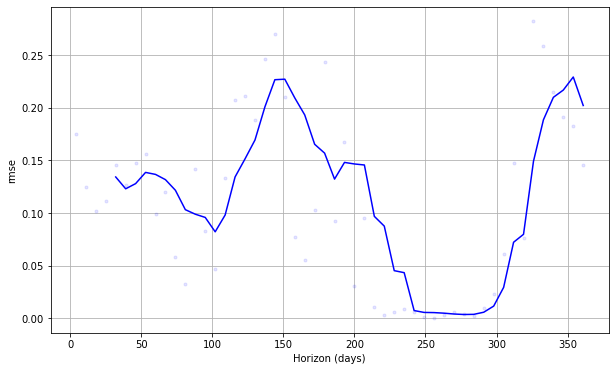

In [68]:
# no difference
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    n_changepoints=25
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       687.822   0.000199667       43.4729   4.973e-06       0.001      129  LS failed, Hessian reset 
      99       687.825   3.94991e-07        39.612     0.00735           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       687.873   3.80841e-06        39.457       2.688      0.2688      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       687.874   3.52539e-06       32.8373   8.947e-08       0.001      347  LS failed, Hessian reset 
     218       687.874   6.60073e-08       31.6179       0.298           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


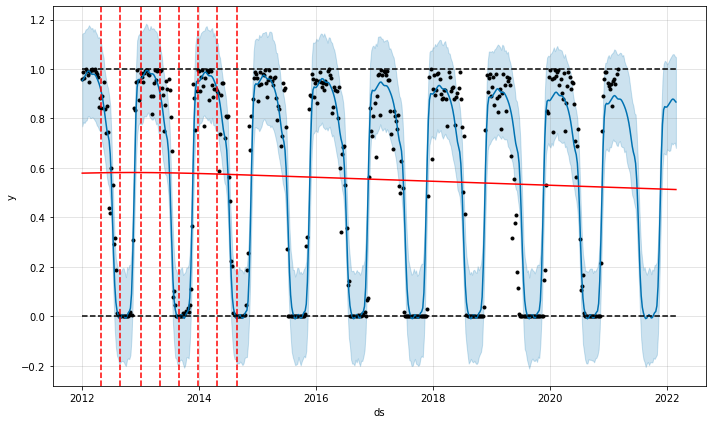

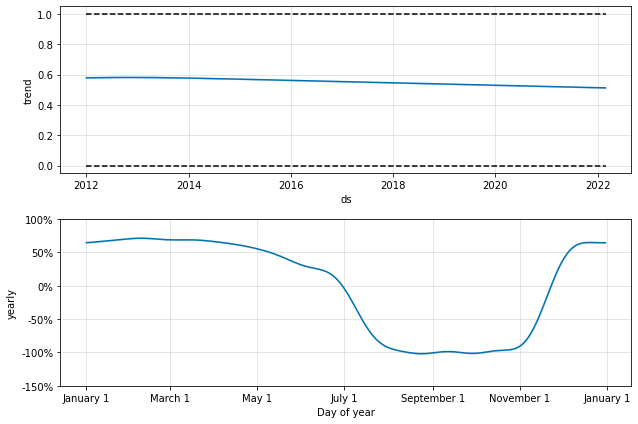

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       592.058   3.50906e-06       21.4749   1.391e-07       0.001      147  LS failed, Hessian reset 
      88       592.059   2.60449e-06       26.0436   7.153e-08       0.001      223  LS failed, Hessian reset 
      95       592.059    7.3838e-08       21.2753      0.2271     0.09445      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.126418
std       0.079427
min       0.002021
25%       0.065226
50%       0.147881
75%       0.173093
max       0.251695
Name: rmse, dtype: float64


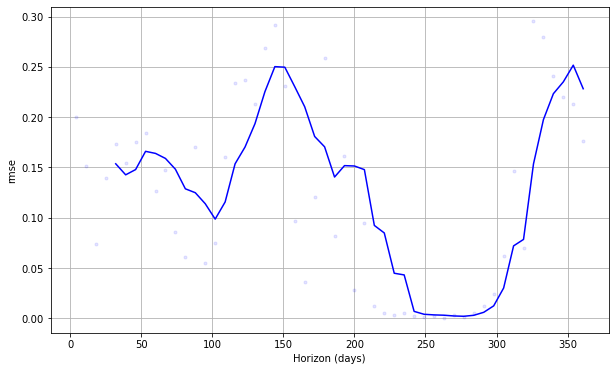

In [69]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.1
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       691.764     0.0170479       12.0553      0.8212      0.8212      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       691.896    0.00164522       13.1685    0.000134       0.001      199  LS failed, Hessian reset 
     199       692.085   7.03921e-05       16.7259      0.3244           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       692.085    1.2211e-05       11.4687   1.203e-06       0.001      348  LS failed, Hessian reset 
     244       692.086   1.06634e-06       9.69991   8.892e-08       0.001      443  LS failed, Hessian reset 
     245       692.086   3.63439e-07       7.11853           1           1      444   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

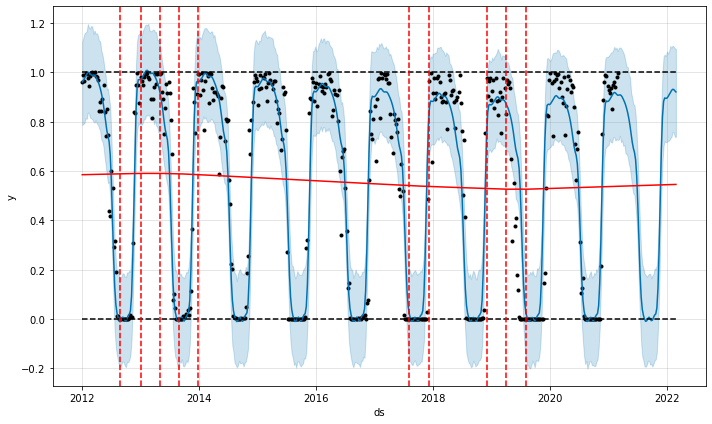

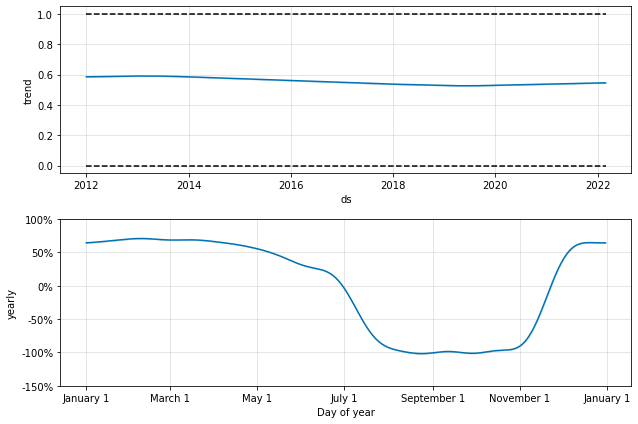

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      37       597.621   0.000418795        7.4957    5.17e-05       0.001       96  LS failed, Hessian reset 
      57        597.63   4.41424e-07       10.3555   9.033e-08       0.001      171  LS failed, Hessian reset 
      62        597.63      1.07e-07       11.0294     0.01334           1      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.145717
std       0.093522
min       0.002028
25%       0.063000
50%       0.162302
75%       0.205214
max       0.292876
Name: rmse, dtype: float64


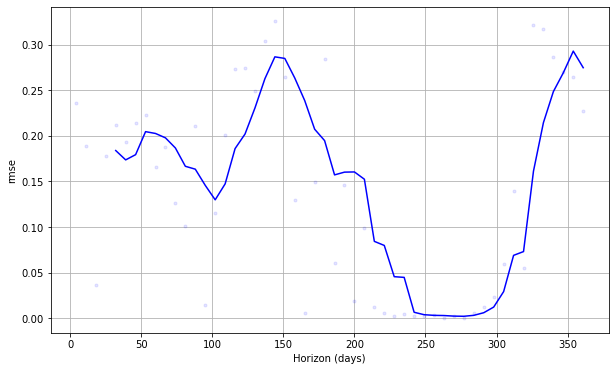

In [70]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.25
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       696.257    0.00460277       6.61486      0.5301      0.5301      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121        696.41     0.0049587       13.2728   0.0003738       0.001      192  LS failed, Hessian reset 
     164       696.452   6.91181e-05       5.39165    1.06e-05       0.001      285  LS failed, Hessian reset 
     199       696.453   2.93825e-05       6.37505           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       696.513   6.77153e-05       5.30921   9.965e-06       0.001      455  LS failed, Hessian reset 
     278       696.514   1.06458e-07       6.28969     0.05513           1      487   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

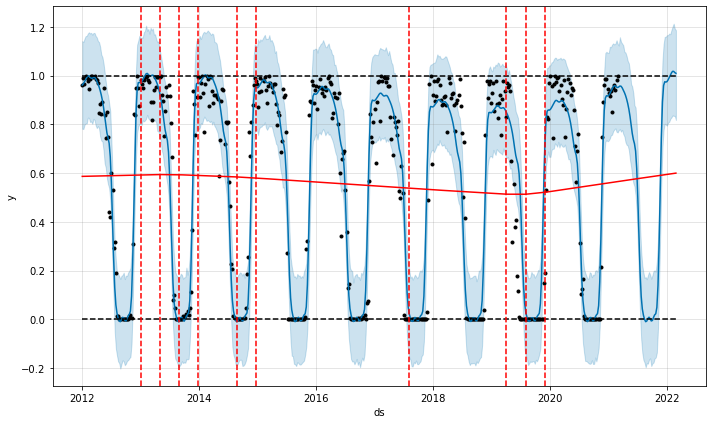

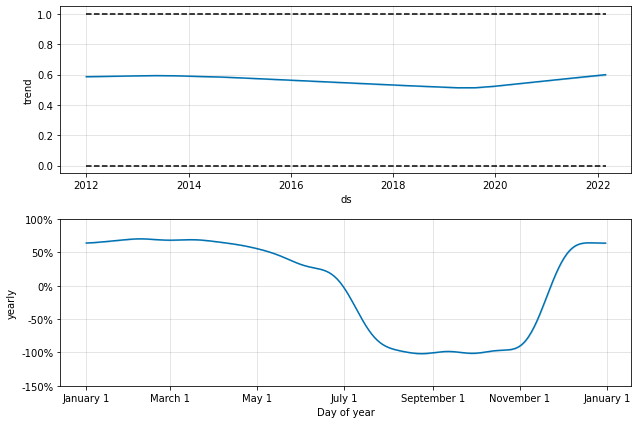

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       602.358    0.00184188       13.1429    0.000158       0.001      153  LS failed, Hessian reset 
      99       602.392   0.000522112       5.56342      0.5623      0.5623      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       602.408   0.000653242       5.14341   0.0001344       0.001      230  LS failed, Hessian reset 
     199       602.418    0.00699014       7.80387           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       602.433   1.68981e-05       5.19843    2.26e-06       0.001      456  LS failed, Hessian reset 
     262       602.434   1.13263e-06       5.56056     0.08111      0.8585      469   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.202432
std       0.138273
min       0.001703
25%       0.053437
50%       0.250870
75%       0.297459
max       0.424336
Name: rmse, dtype: float64


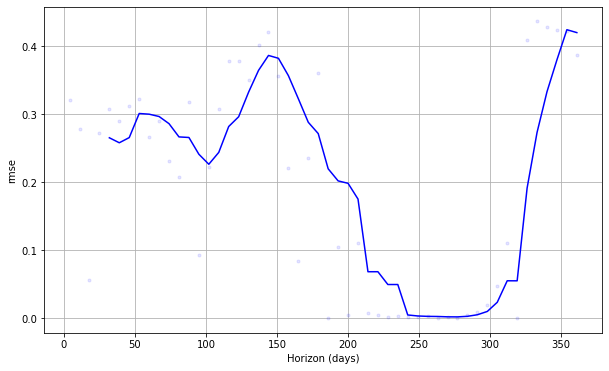

In [71]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.5
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Model G - Yearly seasonablity, weekly values, logistic, change_point (0.9) + seasonality_prior_sacle

Model notes:
- Multiplicative seasonality
- logistic model
- Explore seasonality_prior_scale

Data notes:
- Weekly values with columns of cap and floor
- Forecast of weekly values also with cap and floor

Notes:
- Many change points are missed, but much better in early part of time series
- Trend is better
- More change points found and over all seems slightly improved

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       689.952   0.000963234       10.1569   6.014e-05       0.001       93  LS failed, Hessian reset 
      70        689.96   6.34075e-08       9.75639   4.956e-09       0.001      189  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


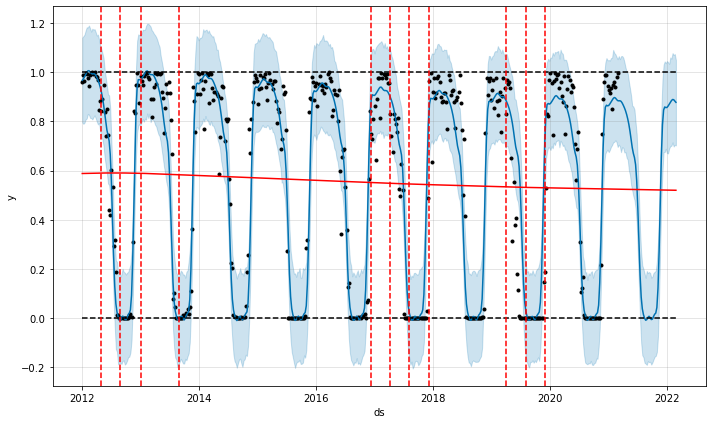

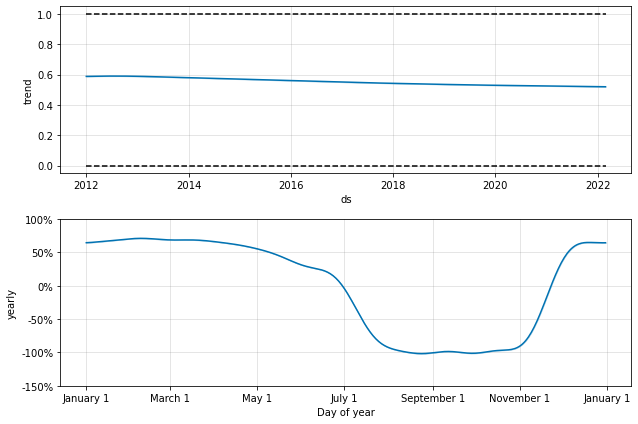

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      38       596.129   5.99644e-06       5.69028   6.344e-07       0.001      122  LS failed, Hessian reset 
      52       596.139   0.000430621       9.34828    7.77e-05       0.001      188  LS failed, Hessian reset 
      60        596.14   5.67496e-06       12.1902   5.733e-07       0.001      241  LS failed, Hessian reset 
      70       596.146   0.000250909       11.8545   1.598e-05       0.001      293  LS failed, Hessian reset 
      83       596.146   1.13284e-06       12.4461   1.212e-07       0.001      361  LS failed, Hessian reset 
      84       596.146   4.45258e-07       5.51875           1           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.139633
std       0.088887
min       0.002089
25%       0.064000
50%       0.157067
75%       0.194460
max       0.279186
Name: rmse, dtype: float64


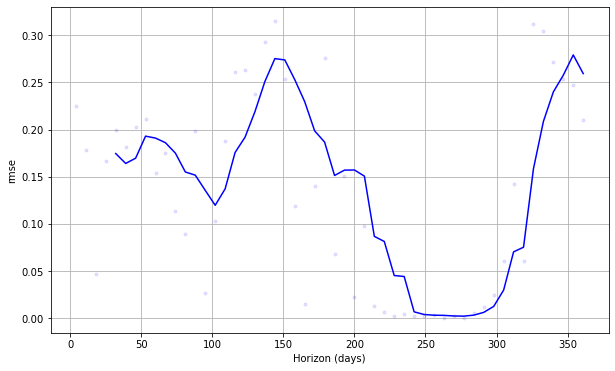

In [72]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=1
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       690.449   0.000725188       13.9082   5.307e-05       0.001      139  LS failed, Hessian reset 
      84       690.452   2.34283e-06       9.30756   1.597e-07       0.001      204  LS failed, Hessian reset 
      89       690.452   3.38252e-09        10.801    0.006968      0.1999      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


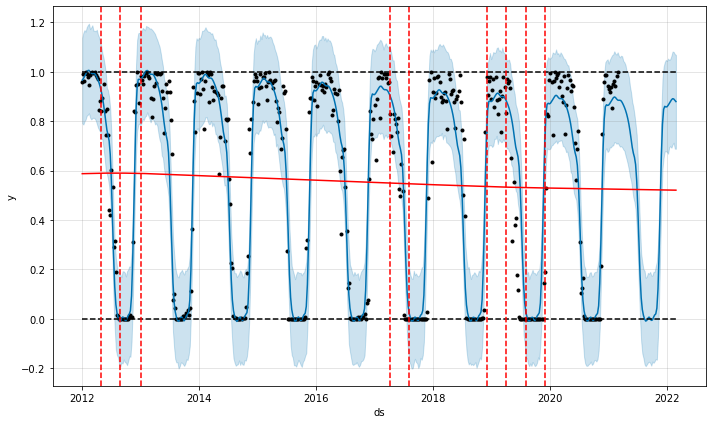

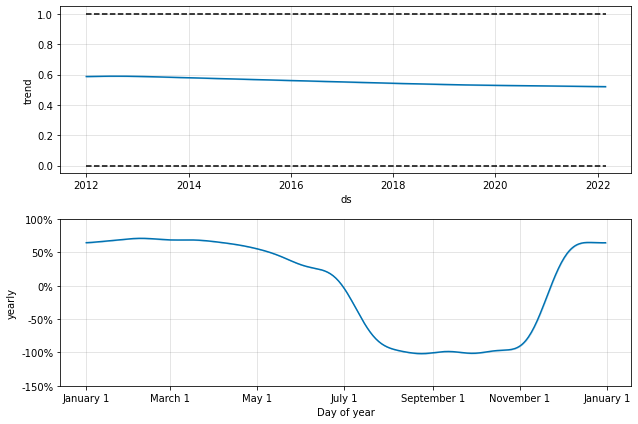

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       596.605   0.000633151       9.39579   0.0001109       0.001      113  LS failed, Hessian reset 
      60       596.624   0.000333002       9.47738   2.075e-05       0.001      189  LS failed, Hessian reset 
      79       596.629   5.27522e-05        12.282   3.346e-06       0.001      255  LS failed, Hessian reset 
      96        596.63    2.1139e-05       14.0054   1.561e-06       0.001      322  LS failed, Hessian reset 
      99        596.63   4.48486e-06       14.0397           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        596.63   1.32124e-06       9.92142   1.115e-07       0.001      364  LS failed, Hessian reset 
     103        596.63   3.39946e-07       5.57037      0.6681      0.6681      365   
Optimization terminated normally: 
  Convergen

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.139692
std       0.088961
min       0.002028
25%       0.063906
50%       0.157100
75%       0.194590
max       0.279351
Name: rmse, dtype: float64


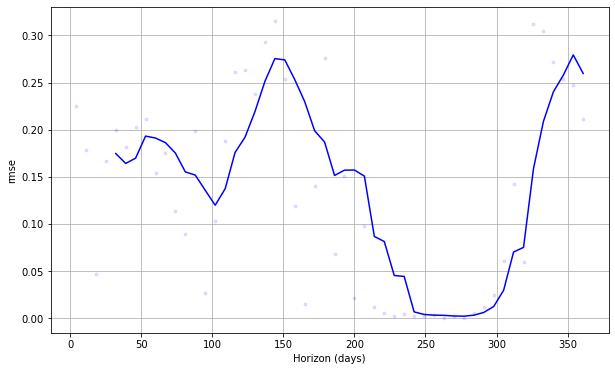

In [73]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=5
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       690.458      0.002948       19.2884   0.0001936       0.001      142  LS failed, Hessian reset 
      99       690.471   7.45959e-05       17.4249      0.8045      0.8045      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       690.472   1.28983e-07       13.5549      0.2495      0.9831      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


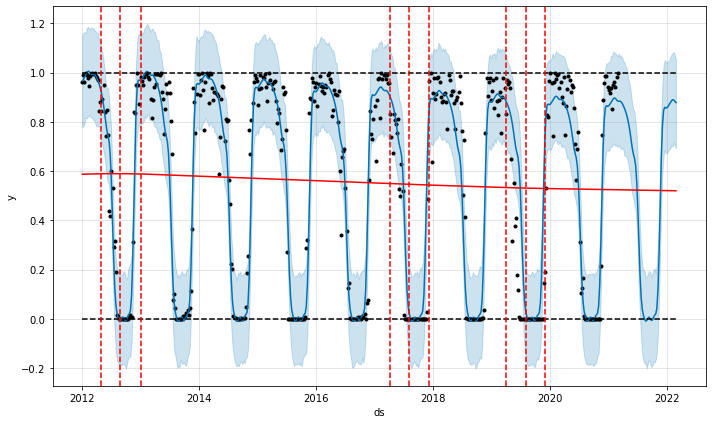

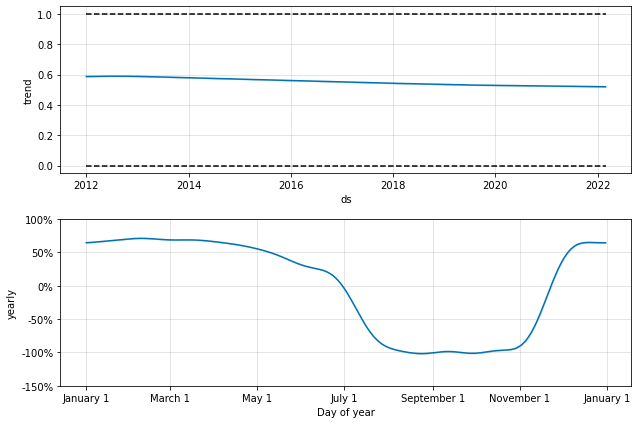

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       596.634   0.000117723       9.92221   9.859e-06       0.001      116  LS failed, Hessian reset 
      50       596.634   6.36837e-05       12.4624   1.127e-05       0.001      156  LS failed, Hessian reset 
      99       596.652    1.6072e-06       14.1564       1.084      0.3096      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       596.653   8.26931e-05       13.0591   7.602e-06       0.001      315  LS failed, Hessian reset 
     121       596.654   1.22305e-06       11.9155   2.104e-07       0.001      363  LS failed, Hessian reset 
     132       596.654   1.17919e-07       9.45199      0.0711           1      382   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.139740
std       0.088993
min       0.002018
25%       0.063892
50%       0.157119
75%       0.194708
max       0.279378
Name: rmse, dtype: float64


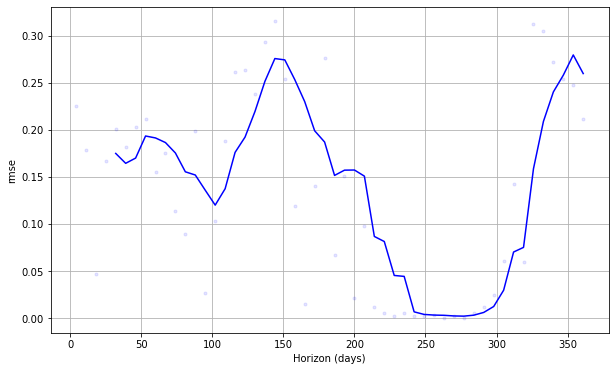

In [74]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=20
)
basic.fit(weekly)
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

## Build models with additional variables

### Load additional variables

Oh yeah, sst is 2012 - present.  But, ocean is only 2019 - present.  Shit.

It seems quite likely that thickness is correlated with concentration, so there may be an opportunity to create another model to represent thickness.  That can then be added in.

In [77]:
variables = {
    'sst.nc': 'POT_GDS0_DBSL_ave6h', 
    'ice_thk.nc': 'ICETK_GDS0_SFC_ave6h',
    'temp.nc': 'TMP_GDS0_SFC_ave6h'
}

var_dfs = []
for fname, var in variables.items():
    var_dfs.append(load_data_local(f'../data/station-data/PABRC-{fname}', var))
    
var_df = pd.concat(var_dfs)  
weekly_df = var_df.resample('W').mean()

In [79]:
variables = {
    'sst.nc': 'POT_GDS0_DBSL_ave6h', 
}

var_dfs = []
for fname, var in variables.items():
    var_dfs.append(load_data_local(f'../data/station-data/PABRC-{fname}', var))
    
var_df = pd.concat(var_dfs)  
weekly_df = var_df.resample('W').mean()
weekly_df

POT_GDS0_DBSL_ave6h
2012-01-01           271.549988
2012-01-08           271.582855
2012-01-15           271.525726
2012-01-22           271.537140
2012-01-29           271.507141
...                         ...
2021-01-31           271.524292
2021-02-07           271.538574
2021-02-14           271.518555
2021-02-21           271.547150
2021-02-28           271.579987

[479 rows x 1 columns]

### Add SST to ice concentration

Model 2C is the best thus far.

In [80]:
weekly['sst'] = weekly_df.values

In [81]:
weekly

ds         y  cap  floor         sst
0   2012-01-01  0.960000  1.0    0.0  271.549988
1   2012-01-08  0.989714  1.0    0.0  271.582855
2   2012-01-15  0.963429  1.0    0.0  271.525726
3   2012-01-22  0.998571  1.0    0.0  271.537140
4   2012-01-29  0.991714  1.0    0.0  271.507141
..         ...       ...  ...    ...         ...
474 2021-01-31  0.949857  1.0    0.0  271.524292
475 2021-02-07  0.961429  1.0    0.0  271.538574
476 2021-02-14  0.941286  1.0    0.0  271.518555
477 2021-02-21  0.981571  1.0    0.0  271.547150
478 2021-02-28  0.998714  1.0    0.0  271.579987

[479 rows x 5 columns]

#### Model 2A - Model F + SST

Model notes:
- Same as Model F
- Add sst as additional multiplicatibe regressor

Data notes:
- Same as Model F
- Add sst.  SST for forecast is just copied from last year.  Could create model for this.

Notes:
- Physically unrealistic data (negative values).
- Max error improved, but overall model is worse than Model F.

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       730.937    0.00432416       75.8449   4.435e-05       0.001      134  LS failed, Hessian reset 
      99       731.109   1.57144e-07        74.049      0.2261           1      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       731.109   2.68612e-08       66.8131      0.2628      0.2628      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

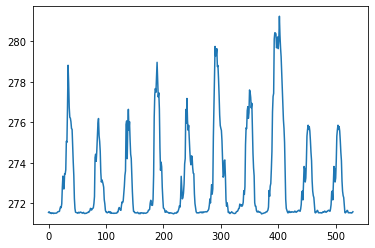

In [82]:
# Same model as Model F
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
# Add SST as a regressor
basic.add_regressor('sst')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp

# seems wrong and bad, but good to get method down.
week_future['sst'].plot()

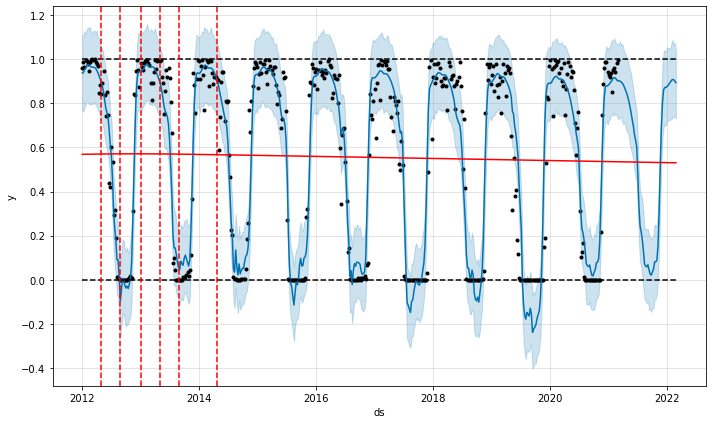

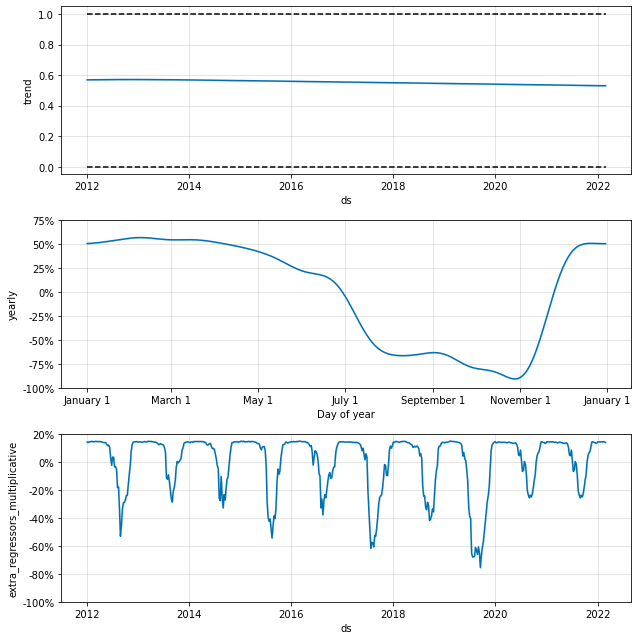

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       631.179    0.00016204       48.1229   2.206e-06       0.001       97  LS failed, Hessian reset 
      82       631.189   1.18769e-05       51.7046   1.792e-07       0.001      215  LS failed, Hessian reset 
      99       631.189   8.99473e-07       55.6064      0.8952      0.8952      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       631.189   2.37313e-07        60.095   4.416e-09       0.001      324  LS failed, Hessian reset 
     124       631.189   4.95891e-08       39.9728      0.3903           1      327   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.127844
std       0.048167
min       0.033555
25%       0.094944
50%       0.128049
75%       0.155128
max       0.212073
Name: rmse, dtype: float64


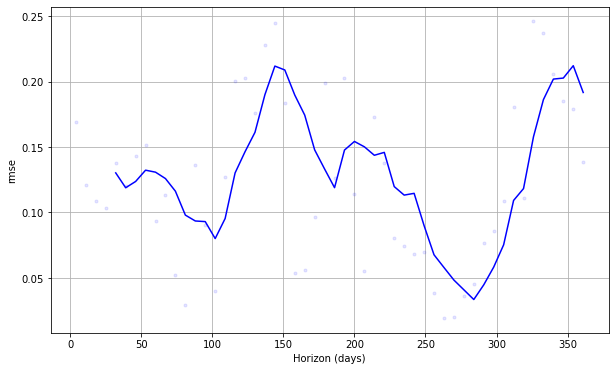

In [84]:
forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

#### Model 2B - Model F + SST (additive)

Model notes:
- Same as Model F
- Add sst as additional multiplicatibe regressor

Data notes:
- Same as Model F
- Add sst.  SST for forecast is just copied from last year.  Could create model for this.

Notes:
- Physically unrealistic data (negative values).
- Max error improved than 2A, but overall model is worse than Model F.

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       729.082   7.10995e-07       71.1486   9.738e-09       0.001      181  LS failed, Hessian reset 
      99       729.083    7.2607e-08       69.2551      0.7958      0.7958      193   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       729.083   2.28026e-08       75.4362      0.3453           1      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


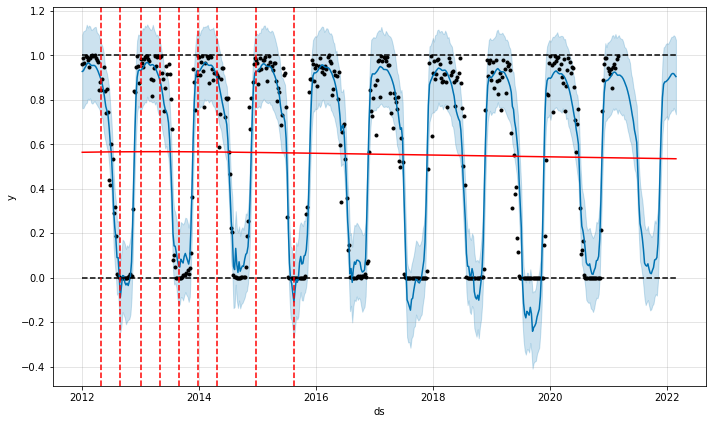

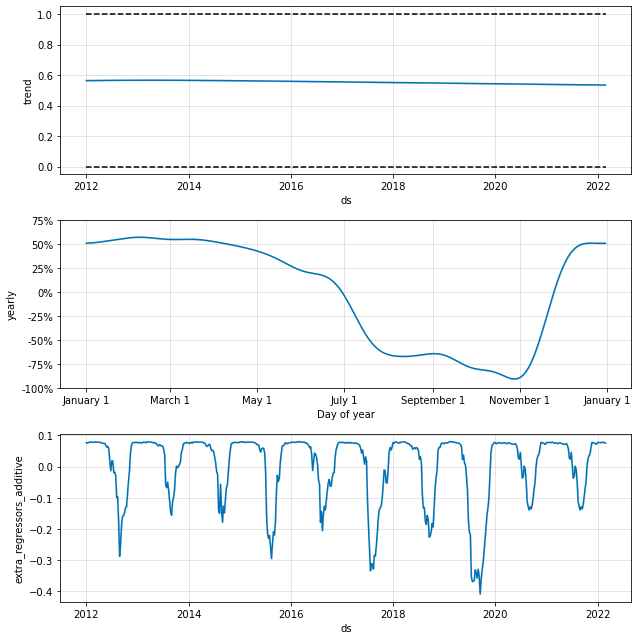

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       627.637   3.51679e-05       71.5498   5.995e-07       0.001      137  LS failed, Hessian reset 
      89        627.64   3.50802e-06       53.1554    5.63e-08       0.001      208  LS failed, Hessian reset 
      99        627.64   1.22032e-07       64.3441      0.4328      0.4328      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115        627.64   3.24943e-08       65.4538      0.3199           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.118742
std       0.047185
min       0.027372
25%       0.084569
50%       0.115334
75%       0.148956
max       0.196578
Name: rmse, dtype: float64


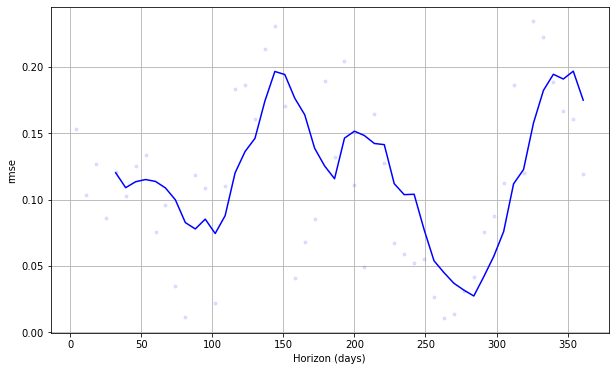

In [85]:
# Same model as Model F
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
# Add SST as a regressor
basic.add_regressor('sst', mode='additive')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

#### Model 2C - Model F + SST (multiplicative + prior_scale)

Model notes:
- Same as Model F
- Add sst as additional multiplicatibe regressor

Data notes:
- Same as Model F
- Add sst.  SST for forecast is just copied from last year.  Could create model for this.

Notes:
- Physically unrealistic data (negative values).
- Max error improved than 2A, but overall model is worse than Model F.

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       730.891   5.22997e-06       75.8945   6.537e-08       0.001      147  LS failed, Hessian reset 
      94       730.891   1.08729e-07        74.183           1           1      172   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


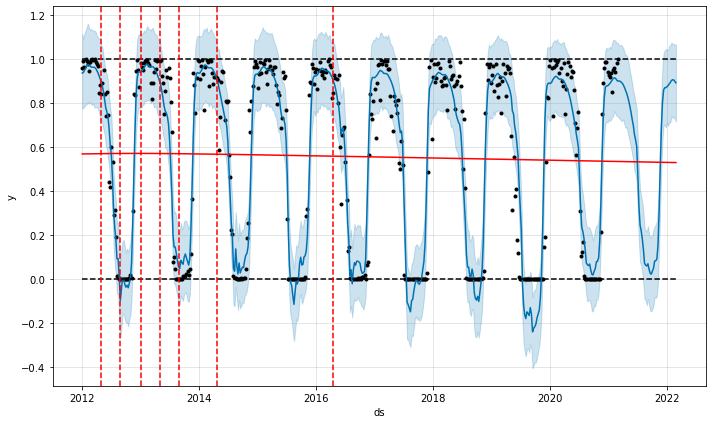

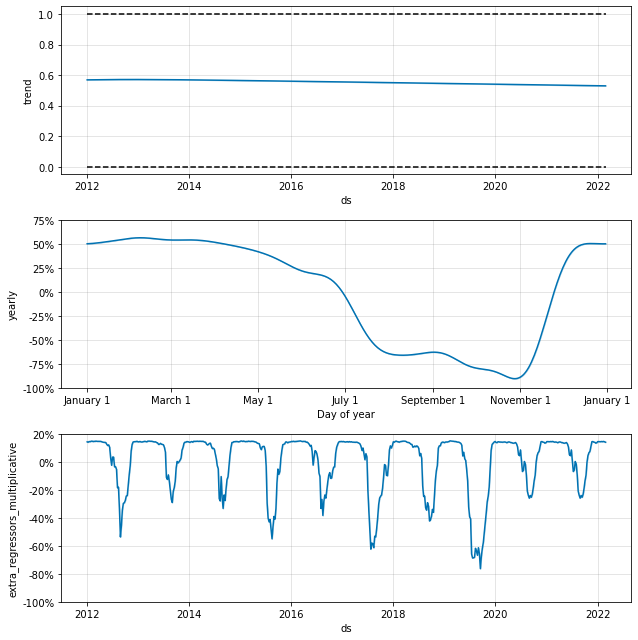

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       631.233   4.73442e-05       67.9301   7.787e-07       0.001      119  LS failed, Hessian reset 
      95       631.235   5.75652e-08       55.2939           1           1      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.127674
std       0.048157
min       0.033337
25%       0.094805
50%       0.127874
75%       0.155026
max       0.211783
Name: rmse, dtype: float64


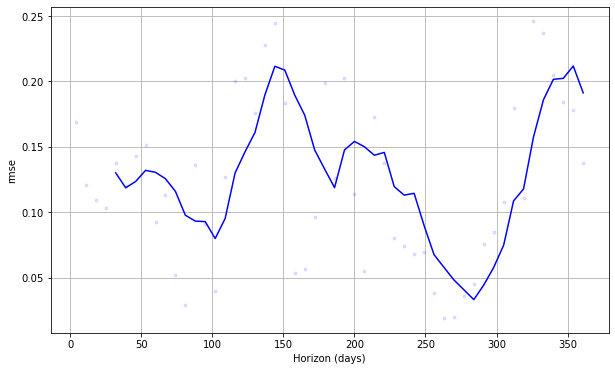

In [86]:
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
# Add SST as a regressor
basic.add_regressor('sst', prior_scale=1)
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

#### [Best] Model 2C - Model F + SST (multiplicative + don't normalize)

Model notes:
- Same as Model F
- Add sst as additional multiplicatibe regressor

Data notes:
- Same as Model F
- Add sst.  SST for forecast is just copied from last year.  Could create model for this.

Notes:
- Better model.
- Max error and mean, better than Model F
- Trend seems wrong.

Initial log joint probability = -85.7623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       679.947    0.00206348       157.744           1           1      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       680.703    2.2182e-07         175.3   1.409e-09       0.001      296  LS failed, Hessian reset 
     199       681.153   9.47464e-05        1020.9           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       681.168   7.47623e-07       323.367   7.089e-09       0.001      542  LS failed, Hessian reset 
     299       681.168   3.81277e-07        176.04           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       681.168    3.2676e-07       129.462   3.073e-09       0.001      613  LS failed, Hessian rese

/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


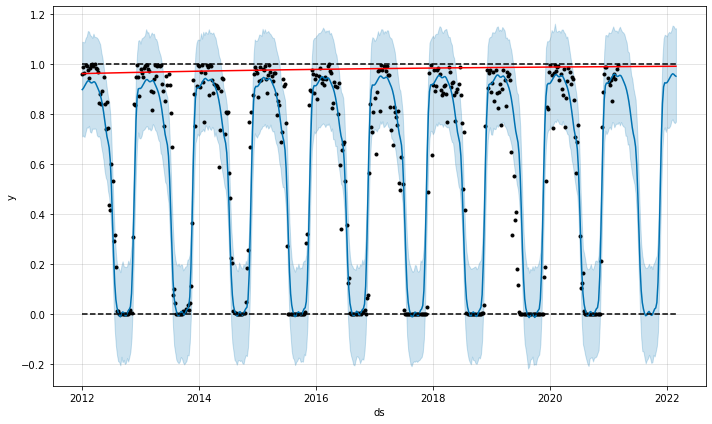

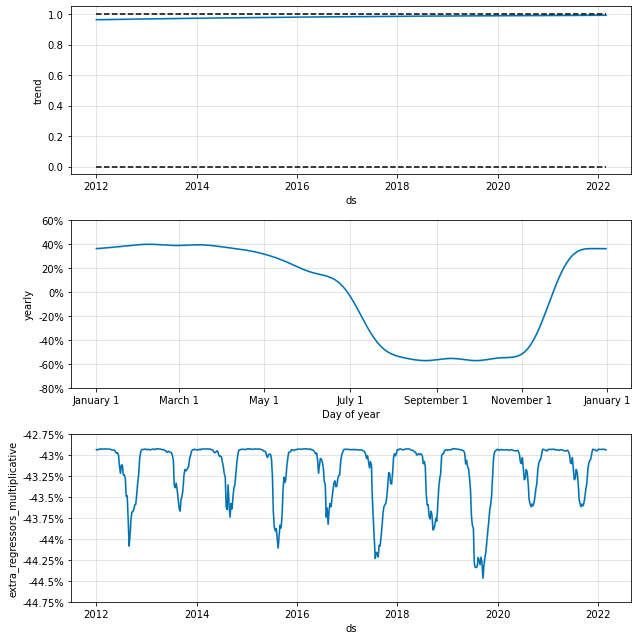

Initial log joint probability = -71.3459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      36       569.854   2.99619e-07       167.795   1.669e-09       0.001      113  LS failed, Hessian reset 
      67       571.423   5.60252e-07       101.925   9.032e-10       0.001      211  LS failed, Hessian reset 
      99       571.596   9.56408e-06       365.444           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        571.64   3.38784e-05       217.681           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     291       571.941   3.63529e-07       107.805   8.833e-10       0.001      571  LS failed, Hessian reset 
     299       572.055   4.45336e-05       356.003      0.4084      0.4084      584   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.082684
std       0.051681
min       0.003785
25%       0.033638
50%       0.101887
75%       0.121674
max       0.162592
Name: rmse, dtype: float64


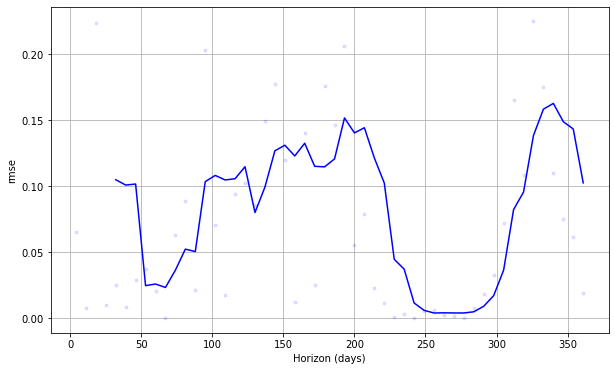

In [87]:
# Same model as Model F
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
# Add SST as a regressor
basic.add_regressor('sst', standardize=False)
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

### Build ice thickness model to use as additional regressor for funsies  - nah.

#### Load ice thickness

In [ ]:
variables = {
    'ice_thk.nc': 'ICETK_GDS0_SFC_ave6h',
}

ice_thickness = load_data_local(f'station-data/PABRC-ice_thk.nc', 'ICETK_GDS0_SFC_ave6h')
    
ice_weekly = ice_thickness.resample('W').mean()

<AxesSubplot:>

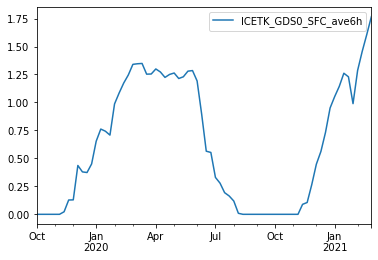

In [ ]:
ice_weekly.plot()

In [ ]:
# subset to a single year
len(ice_weekly.loc['2020-01-01': '2021-01-01'])

52

### Build SST model to use in forecast of ice concentration

In [89]:
# Make df
weekly_sst = pd.DataFrame(
    {
        'ds': weekly['ds'],
        'y': weekly['sst']
    }
)
weekly_sst

ds           y
0   2012-01-01  271.549988
1   2012-01-08  271.582855
2   2012-01-15  271.525726
3   2012-01-22  271.537140
4   2012-01-29  271.507141
..         ...         ...
474 2021-01-31  271.524292
475 2021-02-07  271.538574
476 2021-02-14  271.518555
477 2021-02-21  271.547150
478 2021-02-28  271.579987

[479 rows x 2 columns]

#### Model 3A - Linear air model, multiplicative seasonality

This seems to be the best.

Initial log joint probability = -2.04138
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2461.58    0.00123723       1893.19           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2511.73   0.000428304       778.229           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2523.95   0.000461464        2250.1      0.8238      0.8238      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2545.9     0.0111185       1988.74           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2553.5    0.00593629        2661.1           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
Exception ignored in: <function tqdm.__del__ at 0x7f74a17dc940>
Traceback (most recent call last):
  File "/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


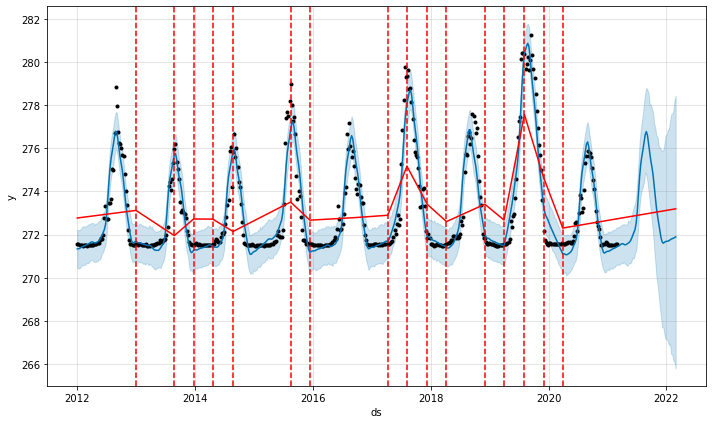

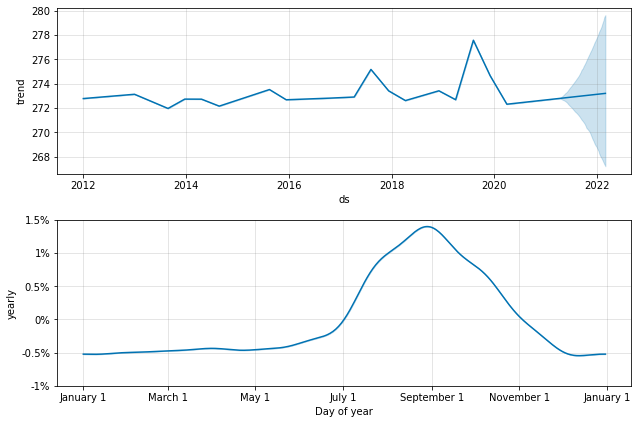

Initial log joint probability = -2.04067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2173.52    0.00154622       1218.31           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2183.66    0.00061062       1367.32           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2186.84   6.56562e-05       317.416           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2188.43    0.00301057       254.418           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2192.29   0.000514283       1077.57      0.8097      0.8097      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

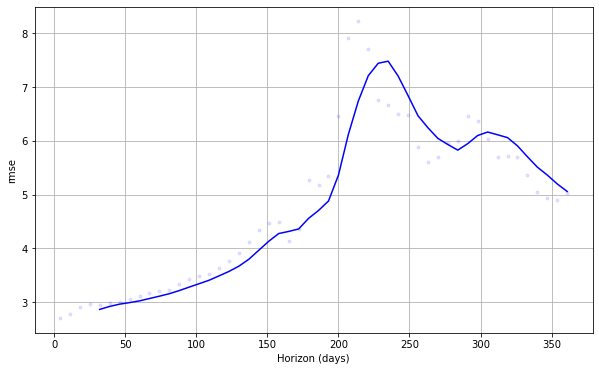

In [90]:
# Same model as Model F
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.fit(weekly_sst)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

#### Model 3B - Linear air model, additive seasonality

Initial log joint probability = -2.04138
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2469.49   0.000815342       2005.66           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2507.29    0.00275347       1265.55           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2515.23   0.000597205        1648.4           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2535.44   0.000998252       1544.55           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2545.38   0.000124683       503.317           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


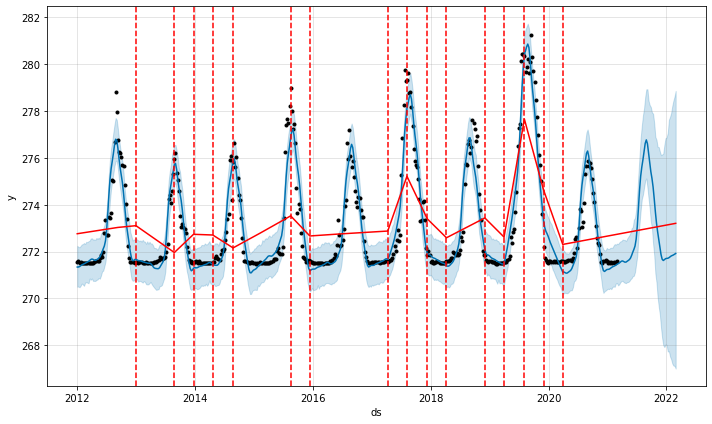

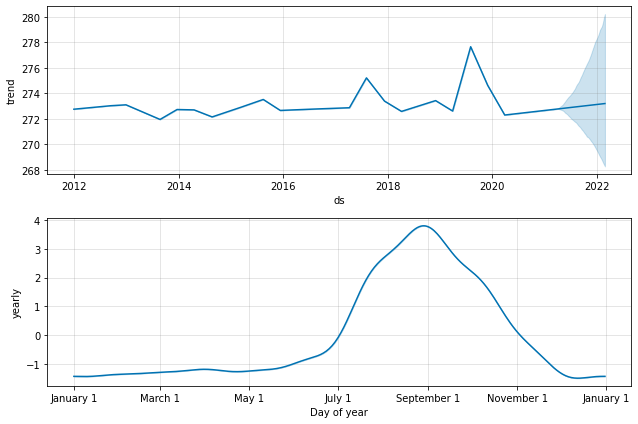

Initial log joint probability = -2.04067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2173.61     0.0011082        473.52           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2177.79   0.000455842       676.595           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2184.88    0.00054981       691.324      0.5833      0.5833      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2186.42   4.53404e-05       386.312      0.3952      0.3952      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2186.99   0.000106892       155.198           1           1      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

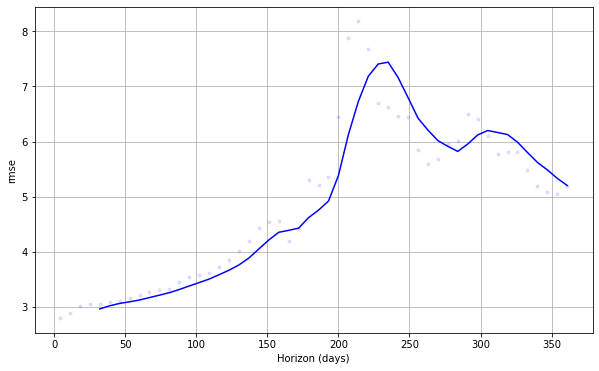

In [91]:
# Same model as Model F
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.9
)
basic.fit(weekly_sst)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

#### Model 3C - Linear air model, additive seasonality, changepoint_prior_scale

Notes:
- Default is 0.05
- Small values permit less change points (probably good in this case, and all?)
- Large values permit more change points
- changepoint_prior_scale=0.01 is a good value

Initial log joint probability = -2.04138
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2442.11   0.000486439       1676.52      0.6566      0.6566      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2447.48   0.000126741       1457.03      0.4296      0.4296      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       2453.22   2.11718e-05       1005.76   1.063e-08       0.001      418  LS failed, Hessian reset 
     299       2453.37   0.000346979       1585.74           1           1      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       2455.51    1.2079e-05       610.037   1.051e-08       0.001      519  LS failed, Hessian reset 
     399       2456.28   3.26499e-05       448.653      0.5764      0.5764      584   
    Iter      log pro

/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


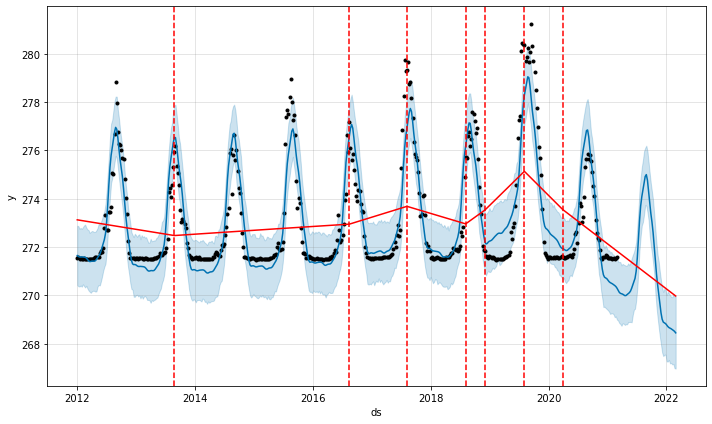

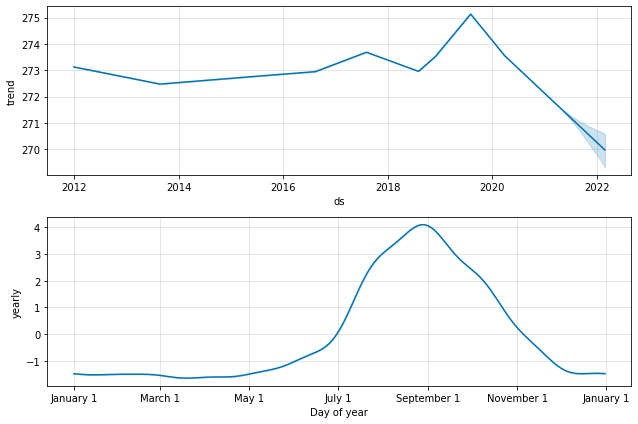

Initial log joint probability = -2.04067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2151.91   1.44731e-05       820.354      0.2868      0.2868      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2154.29   0.000110909       339.558           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2155.18   3.99154e-05       503.036      0.7587      0.7587      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       2155.46   2.38516e-05       468.604   6.566e-08       0.001      490  LS failed, Hessian reset 
     383       2155.46   2.74345e-09       356.361     0.00125      0.8693      515   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
count    48.000000
mean    

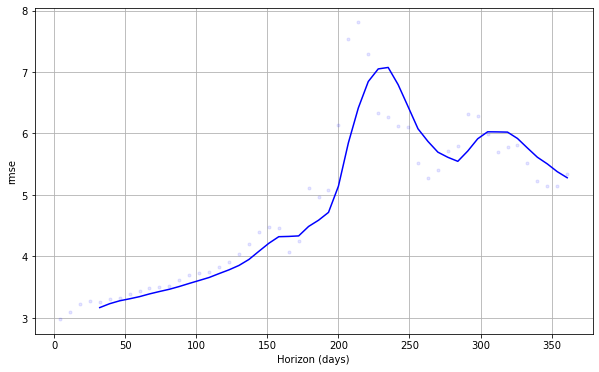

In [92]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.9,
    changepoint_prior_scale=0.01
)
basic.fit(weekly_sst)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

Initial log joint probability = -2.04138
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2464.11    0.00225685       4065.58           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2507.27   0.000218975       2767.05      0.4819      0.4819      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2522.63   0.000225933       811.872      0.2869      0.2869      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2545.26     0.0168215       4976.65           1           1      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2567.89   1.95756e-05          1762      0.2978      0.2978      593   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


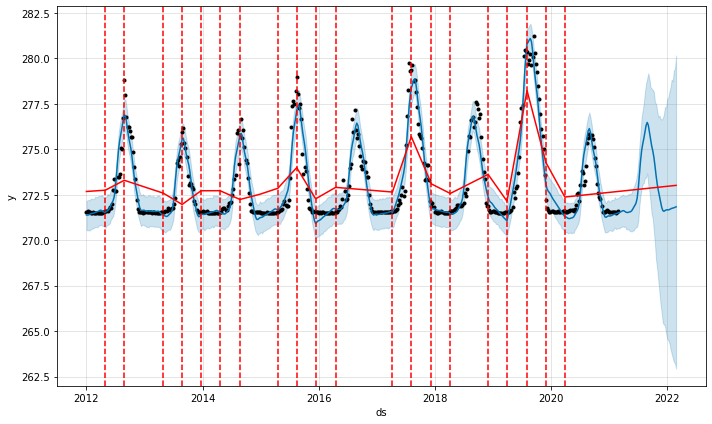

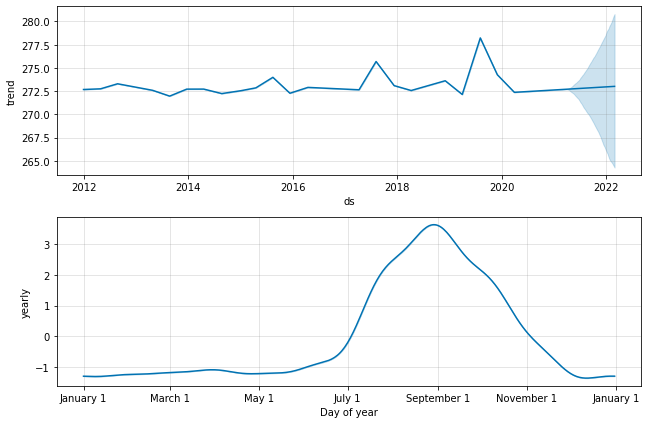

Initial log joint probability = -2.04067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2177.85    0.00135172       982.419           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2192.44    0.00422947       2025.06      0.2027      0.2027      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2196.25    0.00573908       1954.42           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2202.91   0.000651665       1094.35      0.3231           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2205.46   0.000155986       589.923          10           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha  

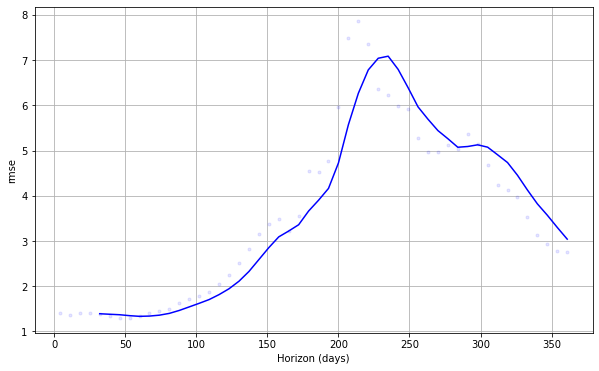

In [93]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.9,
    changepoint_prior_scale=0.1
)
basic.fit(weekly_sst)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

Initial log joint probability = -2.04138
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2469.36     0.0107967       7841.38           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2514.79    0.00505883       3320.07           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2544.35   0.000389421        1165.5           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2566.4   0.000179783       1108.37           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2581.25    0.00115873       1141.96           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


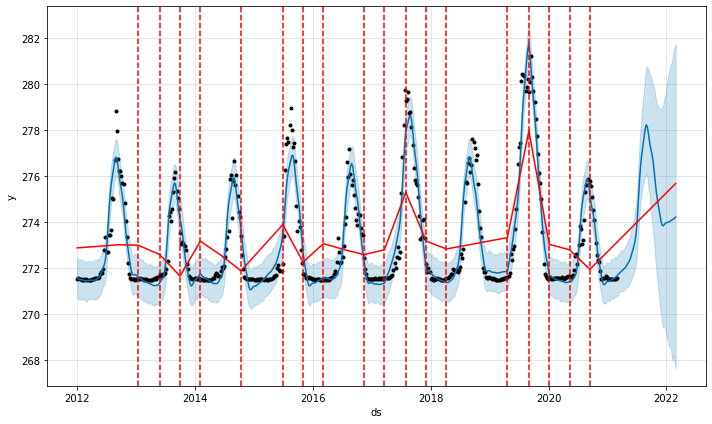

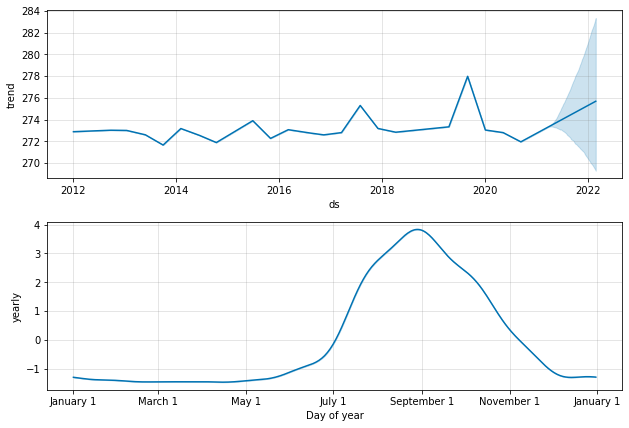

Initial log joint probability = -2.04067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2178.05   0.000253842       909.313           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2198.06     0.0138657       4904.08           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2216.33    0.00057733        1517.9      0.2913           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2225.43    0.00325501       1346.19           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2235.82   0.000228366        1964.3      0.8246      0.8246      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

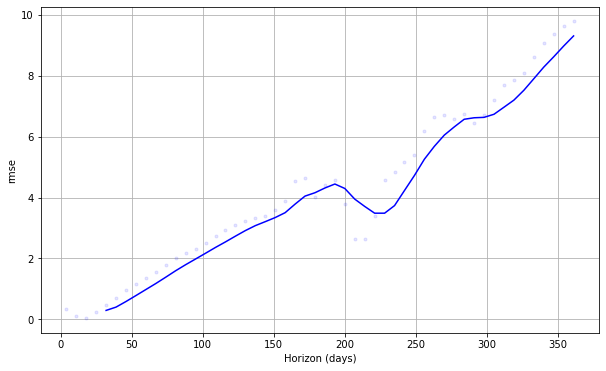

In [94]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.95,
    changepoint_prior_scale=0.1
)
basic.fit(weekly_sst)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

Initial log joint probability = -2.04138
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       2393.71   3.39939e-05       4356.13   7.471e-09       0.001      134  LS failed, Hessian reset 
      96        2393.8   8.96428e-09        4158.2      0.2513      0.2513      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


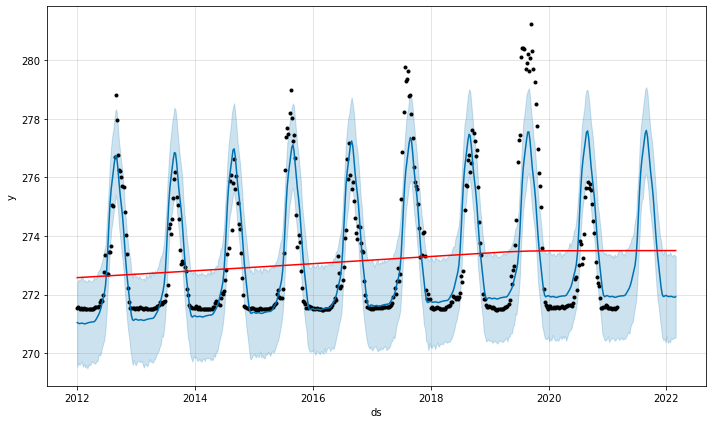

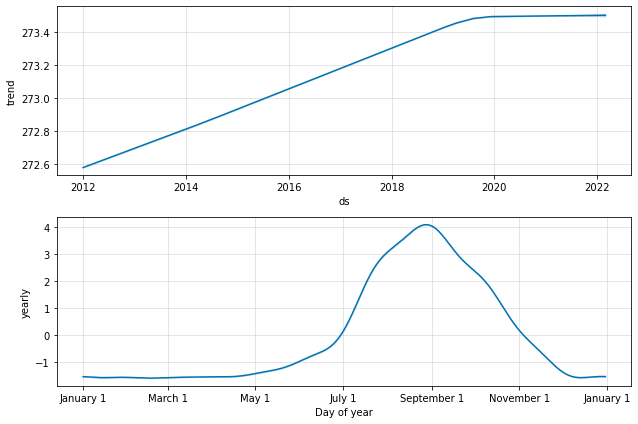

Initial log joint probability = -2.04067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       2113.26   1.80992e-07       2072.58   6.804e-11       0.001      188  LS failed, Hessian reset 
      99       2113.26   1.27412e-07       2605.44           1           1      208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       2113.26   8.74533e-08       2192.33     3.1e-11       0.001      266  LS failed, Hessian reset 
     113       2113.26   5.03169e-09       2334.79      0.3096      0.3096      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
count    48.000000
mean      2.456794
std       0.845627
min       1.583347
25%       1.679369
50%       2.183165
75%       2.957667
max       4.443822
Name: rmse, dtype: float64


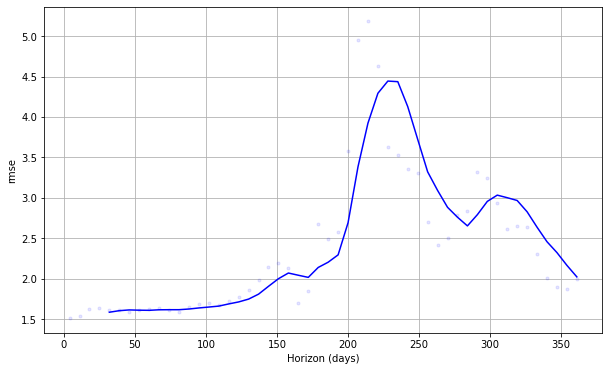

In [95]:
# Same model as Model F
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.9,
    changepoint_prior_scale=0.001
)
basic.fit(weekly_sst)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

Initial log joint probability = -2.04138
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2424.52   0.000136647       1824.84      0.6063      0.6063      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2427.68   6.76495e-06       593.215      0.7401      0.7401      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       2427.93   4.95242e-05       1194.34   6.167e-08       0.001      344  LS failed, Hessian reset 
     299       2428.06   6.06885e-07       833.541       2.025      0.4727      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       2428.06   9.84022e-09       686.002      0.4973      0.4973      443   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


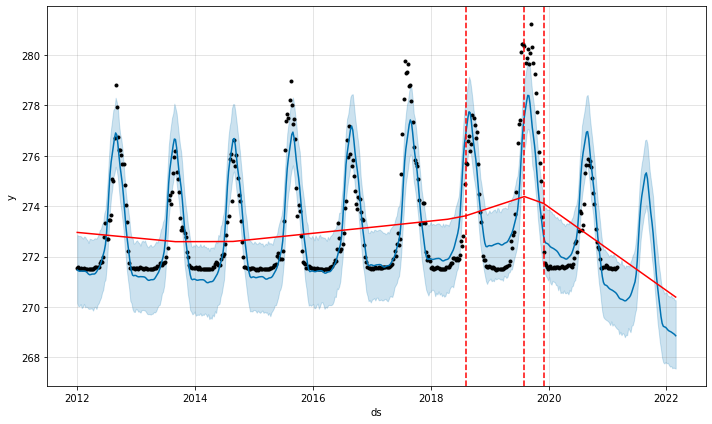

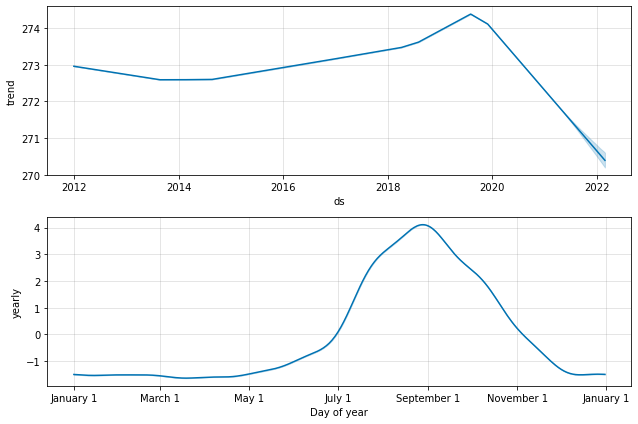

Initial log joint probability = -2.04067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       2141.62   8.14815e-05       1895.87   8.298e-08       0.001      129  LS failed, Hessian reset 
      96       2141.99    2.9414e-05       1014.43   3.822e-08       0.001      202  LS failed, Hessian reset 
      99       2142.02   6.77683e-05       884.014           1           1      205   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       2142.06   4.91342e-06       813.911   7.495e-09       0.001      308  LS failed, Hessian reset 
     199       2142.08      1.88e-06       722.397      0.6781      0.6781      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       2142.08   9.23039e-09       633.325      0.1829      0.1829      410   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

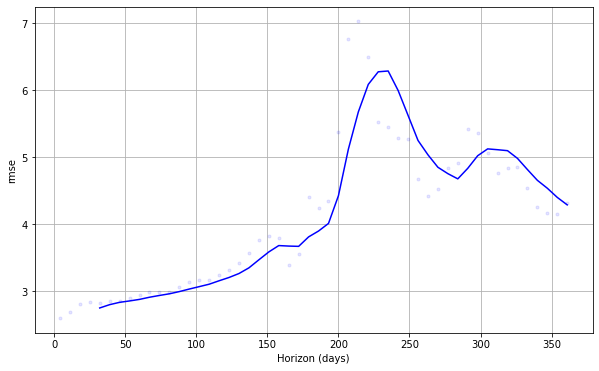

In [96]:
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='additive',
    changepoint_range=0.9,
    changepoint_prior_scale=0.005
)
basic.fit(weekly_sst)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

In [ ]:
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2012-01-01  272.966667  270.111939  272.805656   272.966667   272.966667   
1   2012-01-08  272.961919  270.073074  272.691905   272.961919   272.961919   
2   2012-01-15  272.957171  270.135182  272.703336   272.957171   272.957171   
3   2012-01-22  272.952423  270.092650  272.828623   272.952423   272.952423   
4   2012-01-29  272.947675  270.040375  272.737968   272.947675   272.947675   
..         ...         ...         ...         ...          ...          ...   
526 2022-01-30  270.714287  267.738402  270.491468   270.519489   270.890460   
527 2022-02-06  270.684866  267.807013  270.465736   270.487098   270.865368   
528 2022-02-13  270.655444  267.743785  270.476078   270.449373   270.840272   
529 2022-02-20  270.626022  267.776596  270.383914   270.411680   270.815177   
530 2022-02-27  270.596601  267.703678  270.433537   270.377731   270.790964   

     additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0         -1.496065             -1.496065             -1.496065 -1.496065   
1         -1.522390             -1.522390             -1.522390 -1.522390   
2         -1.535199             -1.535199             -1.535199 -1.535199   
3         -1.527946             -1.527946             -1.527946 -1.527946   
4         -1.517980             -1.517980             -1.517980 -1.517980   
..              ...                   ...                   ...       ...   
526       -1.516941             -1.516941             -1.516941 -1.516941   
527       -1.516727             -1.516727             -1.516727 -1.516727   
528       -1.517805             -1.517805             -1.517805 -1.517805   
529       -1.520652             -1.520652             -1.520652 -1.520652   
530       -1.539188             -1.539188             -1.539188 -1.539188   

     yearly_lower  yearly_upper  multiplicative_terms  \
0       -1.496065     -1.496065                   0.0   
1       -1.522390     -1.522390                   0.0   
2       -1.535199     -1.535199                   0.0   
3       -1.527946     -1.527946                   0.0   
4       -1.517980     -1.517980                   0.0   
..            ...           ...                   ...   
526     -1.516941     -1.516941                   0.0   
527     -1.516727     -1.516727                   0.0   
528     -1.517805     -1.517805                   0.0   
529     -1.520652     -1.520652                   0.0   
530     -1.539188     -1.539188                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                           0.0                         0.0  271.470602  
1                           0.0                         0.0  271.439529  
2                           0.0                         0.0  271.421972  
3                           0.0                         0.0  271.424477  
4                           0.0                         0.0  271.429695  
..                          ...                         ...         ...  
526                         0.0                         0.0  269.197346  
527                         0.0                         0.0  269.168139  
528                         0.0                         0.0  269.137639  
529                         0.0                         0.0  269.105370  
530                         0.0                         0.0  269.057413  

[531 rows x 16 columns]

## Build model best model with MCMC instead of MAP

#### Model 4A - MCMC first attempt, don't know how to select the number of samples.

##### 100 samples, 1 m, similar errors, but UQ for components (mostly SST)


Gradient evaluation took 0.001281 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.81 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 7
           adapt_window = 38
           term_buffer = 5


Gradient evaluation took 0.001247 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.47 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 7
           adapt_window = 38
           term_buffer = 5


Gradient evaluation took 0.001564 seconds
1000 transitions using 10 leapfrog steps per transition would take 15.64 seconds.
Adjust your expectations accordingly!


   

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration: 10 / 100 [ 10%]  (Warmup)
Iteration: 10 / 100 [ 10%]  (Warmup)
Iteration: 10 / 100 [ 10%]  (Warmup)
Iteration: 10 / 100 [ 10%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 60 / 100 [ 60%]  (Sampling)
Iteration: 60 / 100 [ 60%]  (Sampling)
Iteration: 60 / 100 [ 60%]

/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


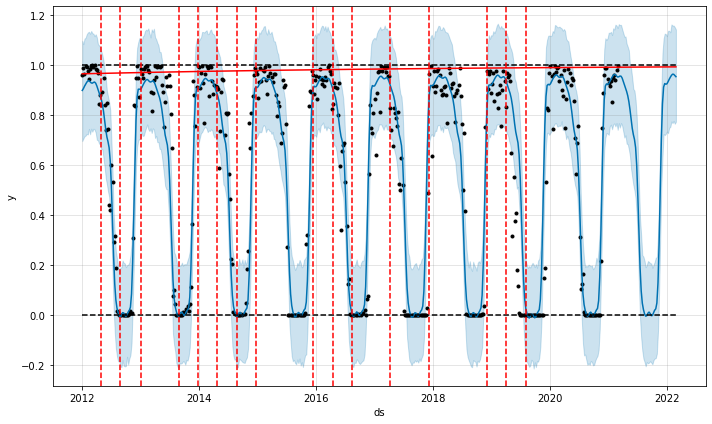

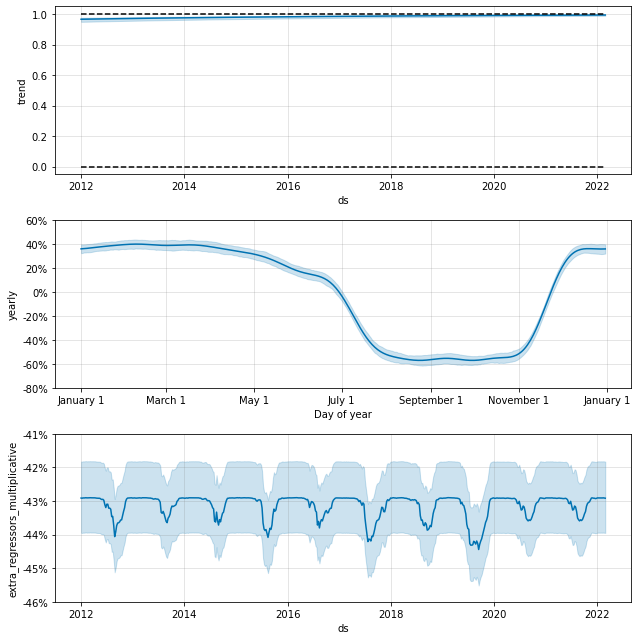


Gradient evaluation took 0.001252 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.52 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:

           init_buffer = 7
           adapt_window = 38
           term_buffer = 5

Gradient evaluation took 0.001281 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.81 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 7
           adapt_window = 38
           term_buffer = 5


Gradient evaluation took 0.001156 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.56 seconds.
Adjust your expectations accordingly!


   

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration: 10 / 100 [ 10%]  (Warmup)
Iteration: 10 / 100 [ 10%]  (Warmup)
Iteration: 10 / 100 [ 10%]  (Warmup)
Iteration: 10 / 100 [ 10%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 20 / 100 [ 20%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 30 / 100 [ 30%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 40 / 100 [ 40%]  (Warmup)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 60 / 100 [ 60%]  (Sampling)
Iteration: 60 / 100 [ 60%]  (Sampling)
Iteration: 50 / 100 [ 50%]  (Warmup)
Iteration: 51 / 100 [ 51%]  (Sampling)
Iteration: 60 / 100 [ 60%]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.082867
std       0.051313
min       0.005379
25%       0.033288
50%       0.101501
75%       0.122056
max       0.161256
Name: rmse, dtype: float64
CPU times: user 2min 34s, sys: 8min 30s, total: 11min 5s
Wall time: 1min 54s


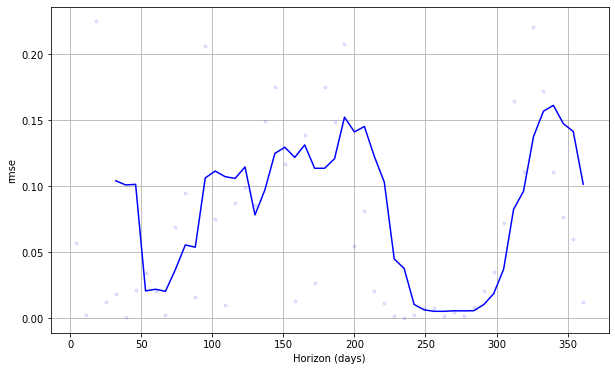

In [97]:
%%time
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    mcmc_samples=100
)
# Add SST as a regressor
basic.add_regressor('sst', standardize=False)
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

##### 500 samples, 43 s, 4 minutes, smoother confidence intervals


Gradient evaluation took 0.001116 seconds
1000 transitions using 10 leapfrog steps per transition would take 11.16 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)

Gradient evaluation took 0.00151 seconds
1000 transitions using 10 leapfrog steps per transition would take 15.1 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001697 seconds
1000 transitions using 10 leapfrog steps per transition would take 16.97 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)

Gradient evaluation took 0.001489 seconds
1000 transitions using 10 leapfrog steps per transition would take 14.89 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration: 100 / 500 [ 20%]  (Warmup)
Iteration: 100 / 500 [ 20%]  (Warmup)
Iteration: 100 / 500 [ 20%]  (Warmup)
Iteration: 100 / 500 [ 20%]  (Warmup)
Iteration: 150 / 500 [ 30%]  (Warmup)
Iteration: 150 / 500 [ 30%]  (Warmup)
Iteration: 150 / 500 [ 30%]  (Warmup)
Iteration: 150 / 500 [ 30%]  (Warmup)
Iteration: 200 / 500 [ 40%]  (Warmup)
Iteration: 200 / 500 [ 40%]  (Warmup)
Iteration: 200 / 500 [ 40%]  (Warmup)
Iteration: 200 / 500 [ 40%]  (Warmup)
Iteration: 250 / 500 [ 50%]  (Warmup)
Iteration: 250 / 500 [ 50%]  (Warmup)
Iteration: 251 / 500 [ 50%]  (Sampling)
Iteration: 251 / 500 [ 50%]  (Sampling)
Iteration: 250 / 500 [ 50%]  (Warmup)
Iteration: 251 / 500 [ 50%]  (Sampling)
Iteration: 250 / 500 [ 50%]  (Warmup)
Iteration: 251 / 500 [ 50%]  (Sampling)
Iteration: 300 / 500 [ 60%]  (Sampling)
Iteration: 300 / 500 [ 60%]  (Sampling)


/home/axiom/miniconda3/envs/s2s/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


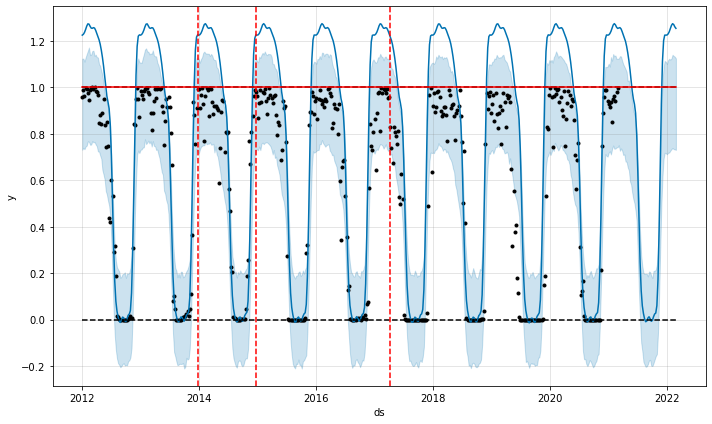

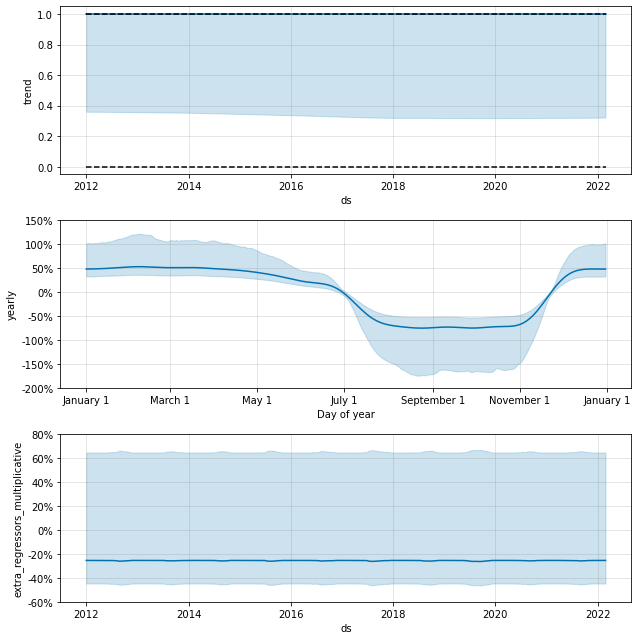


Gradient evaluation took 0.001298 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.98 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001251 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001234 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001257 seconds
1000 transitions using 10 leapfrog steps per transition would take 12.57 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)
Iteration:   1 / 500 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of th

Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration:  50 / 500 [ 10%]  (Warmup)
Iteration: 100 / 500 [ 20%]  (Warmup)
Iteration: 100 / 500 [ 20%]  (Warmup)
Iteration: 100 / 500 [ 20%]  (Warmup)
Iteration: 100 / 500 [ 20%]  (Warmup)
Iteration: 150 / 500 [ 30%]  (Warmup)
Iteration: 150 / 500 [ 30%]  (Warmup)
Iteration: 150 / 500 [ 30%]  (Warmup)
Iteration: 150 / 500 [ 30%]  (Warmup)
Iteration: 200 / 500 [ 40%]  (Warmup)
Iteration: 200 / 500 [ 40%]  (Warmup)
Iteration: 200 / 500 [ 40%]  (Warmup)
Iteration: 200 / 500 [ 40%]  (Warmup)
Iteration: 250 / 500 [ 50%]  (Warmup)
Iteration: 251 / 500 [ 50%]  (Sampling)
Iteration: 250 / 500 [ 50%]  (Warmup)
Iteration: 251 / 500 [ 50%]  (Sampling)
Iteration: 250 / 500 [ 50%]  (Warmup)
Iteration: 251 / 500 [ 50%]  (Sampling)
Iteration: 250 / 500 [ 50%]  (Warmup)
Iteration: 251 / 500 [ 50%]  (Sampling)
Iteration: 300 / 500 [ 60%]  (Sampling)
Iteration: 300 / 500 [ 60%]  (Sampling)


INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      6.742635
std       4.688299
min       0.185018
25%       1.121949
50%       8.599134
75%      11.334327
max      11.812386
Name: rmse, dtype: float64
CPU times: user 2min 46s, sys: 8min 55s, total: 11min 41s
Wall time: 7min 19s


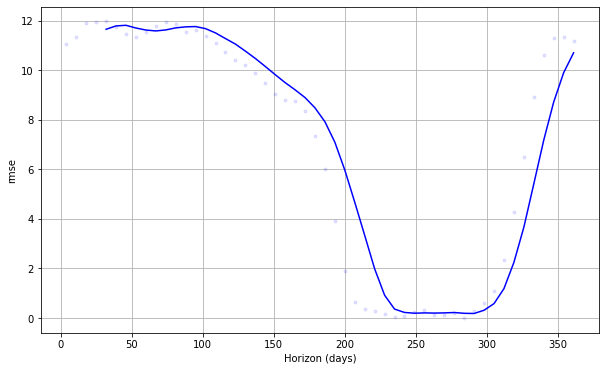

In [98]:
%%time
basic = Prophet(
    growth='logistic',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    mcmc_samples=500
)
# Add SST as a regressor
basic.add_regressor('sst', standardize=False)
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
week_future['cap'] = 1
week_future['floor'] = 0
# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days',
    disable_tqdm=True
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

## Save Model

In [ ]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('serialize-test.json', 'w') as fout:
    json.dump(model_to_json(basic), fout)
    
with open('serialize-test.json') as fin:
    m = model_from_json(json.load(fin))

In [ ]:
m == basic

False

In [ ]:
np.array_equal(m.params, basic.params)

False

In [ ]:
m.params.keys() == basic.params.keys()

True

In [ ]:
for key in m.params.keys():
    diff = np.allclose(m.params[key], basic.params[key])
    print(f'{key}: {diff}')

k: True
m: True
delta: True
sigma_obs: True
beta: True
trend: True


## Build model with derivatives

In [ ]:
# I should take the derivative in daily values, then take the mean for the week.
# - This is fine for now.
air_dt = np.diff(weekly['sst'])
ice_dt = np.diff(weekly['y'])
# add first time step as copy of 1st val in dt
air_dt = np.append(air_dt[0], air_dt)
ice_dt = np.append(ice_dt[0], ice_dt)

air_dt[0] == air_dt[1]

True

In [ ]:
weekly['air-dt'] = air_dt
weekly['ice-dt'] = ice_dt

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


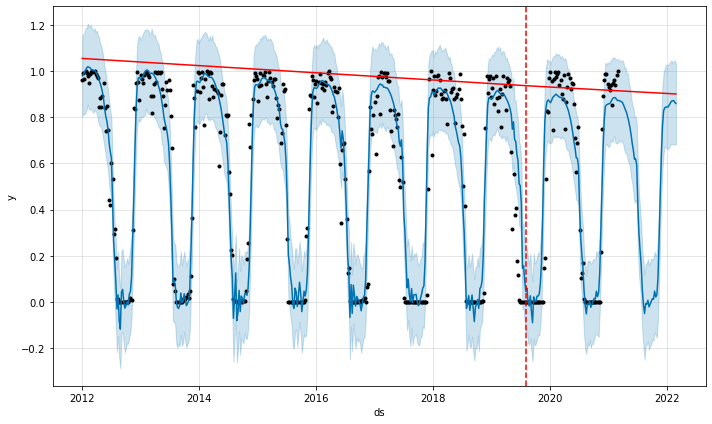

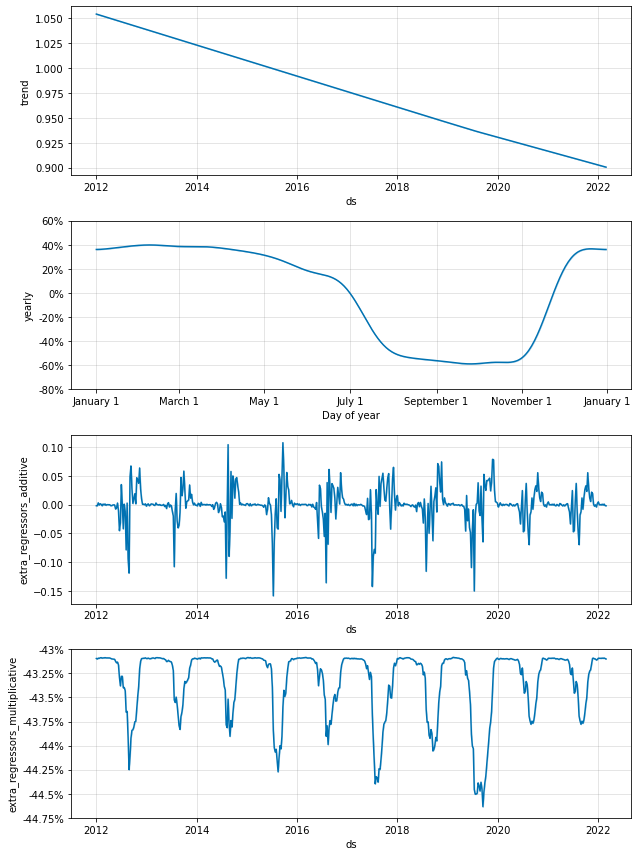

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.130894
std       0.076984
min       0.014386
25%       0.062684
50%       0.137270
75%       0.176851
max       0.264619
Name: rmse, dtype: float64


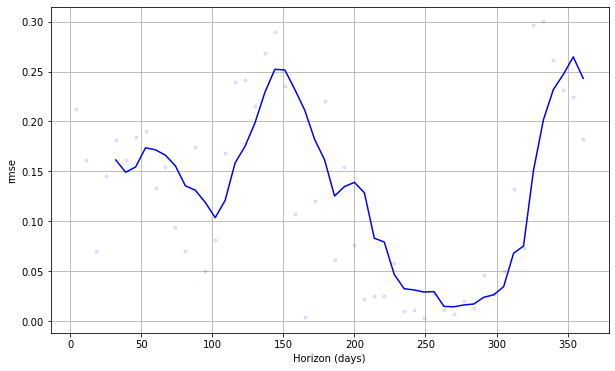

In [ ]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('sst', standardize=False)
basic.add_regressor('air-dt', standardize=False, mode='additive')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


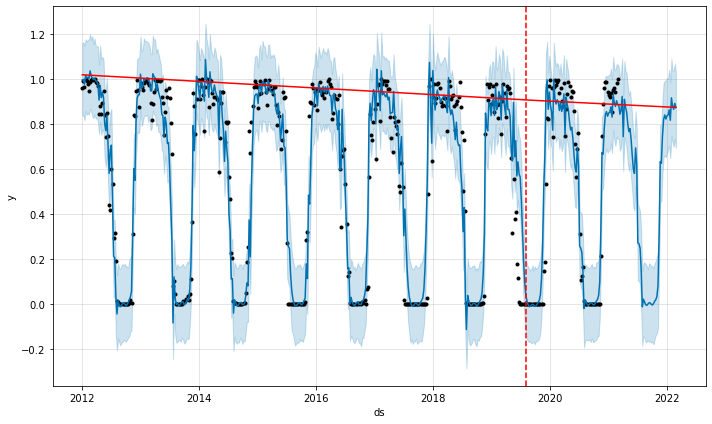

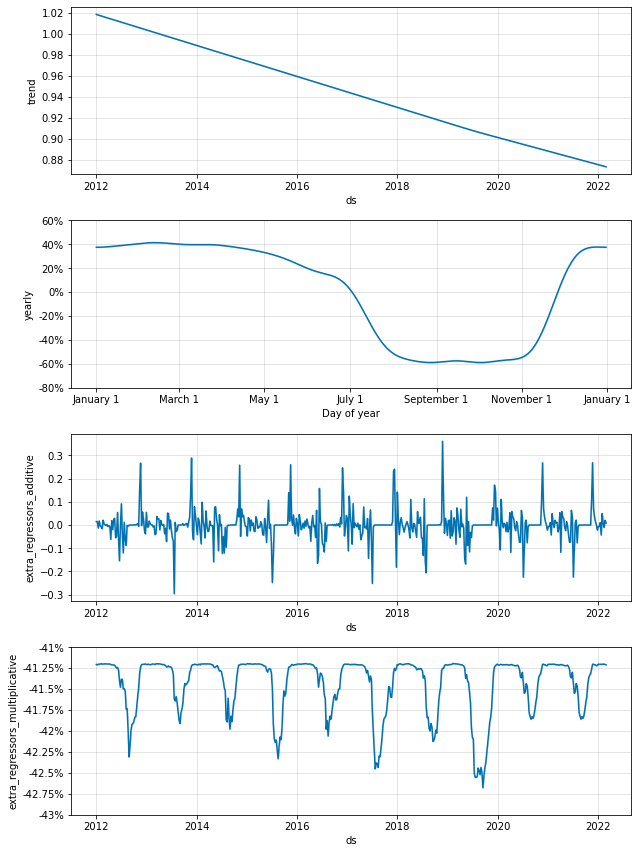

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.123388
std       0.082441
min       0.002118
25%       0.050592
50%       0.132188
75%       0.179036
max       0.264097
Name: rmse, dtype: float64


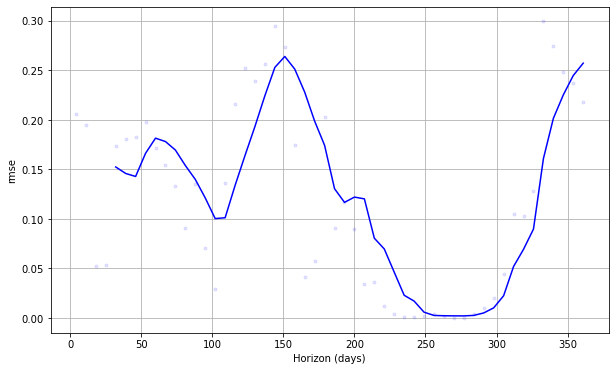

In [ ]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('sst', standardize=False)
basic.add_regressor('ice-dt', standardize=False, mode='additive')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt

# copy ice-dt from last year for first attemp
week_future['ice-dt'] = weekly['ice-dt'].copy()
guess_dt = weekly['ice-dt'].iloc[-52::].values.copy()
week_future['ice-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


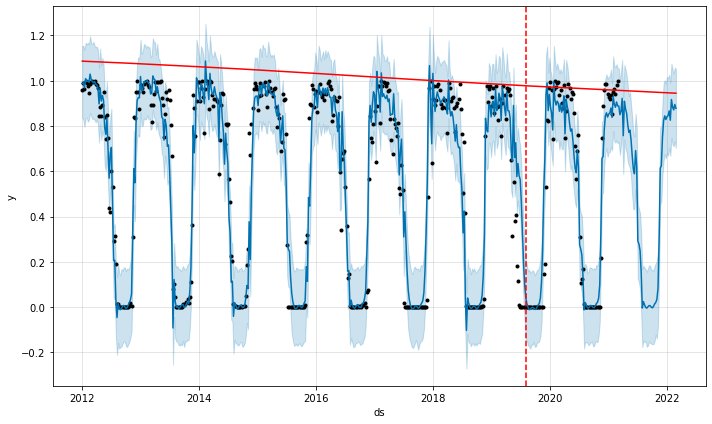

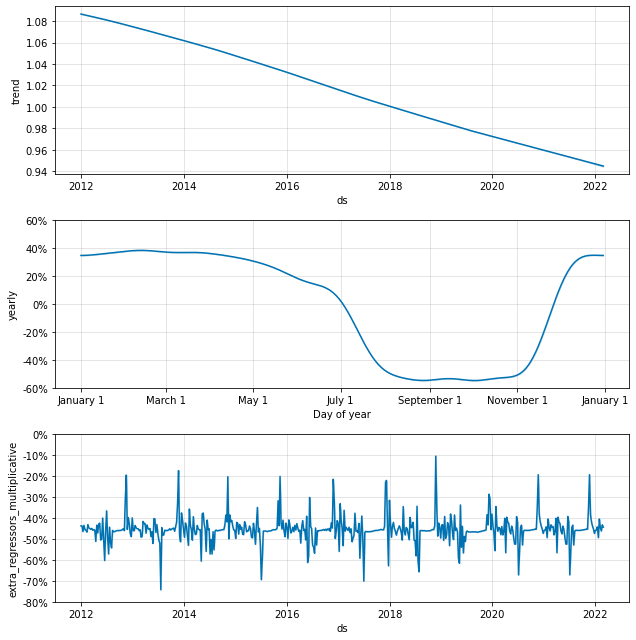

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.119870
std       0.080324
min       0.002164
25%       0.049518
50%       0.125208
75%       0.171419
max       0.255851
Name: rmse, dtype: float64


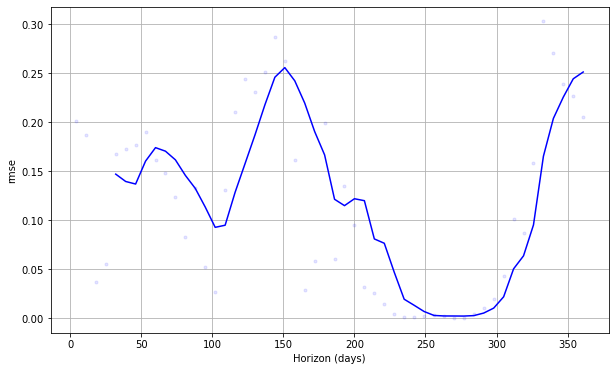

In [ ]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('sst', standardize=False)
basic.add_regressor('ice-dt', standardize=False, mode='multiplicative')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt

# copy ice-dt from last year for first attemp
week_future['ice-dt'] = weekly['ice-dt'].copy()
guess_dt = weekly['ice-dt'].iloc[-52::].values.copy()
week_future['ice-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


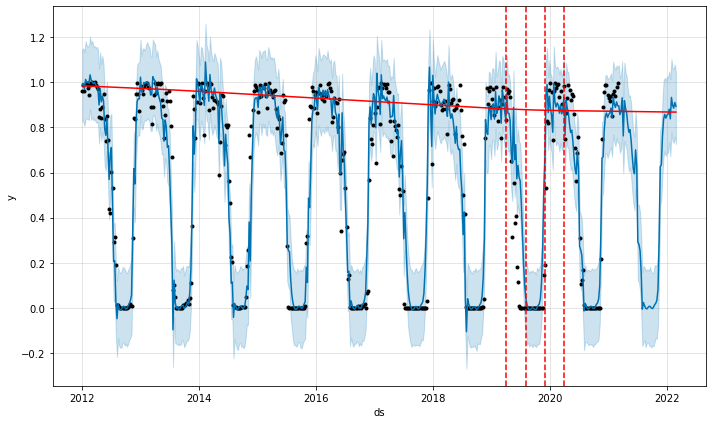

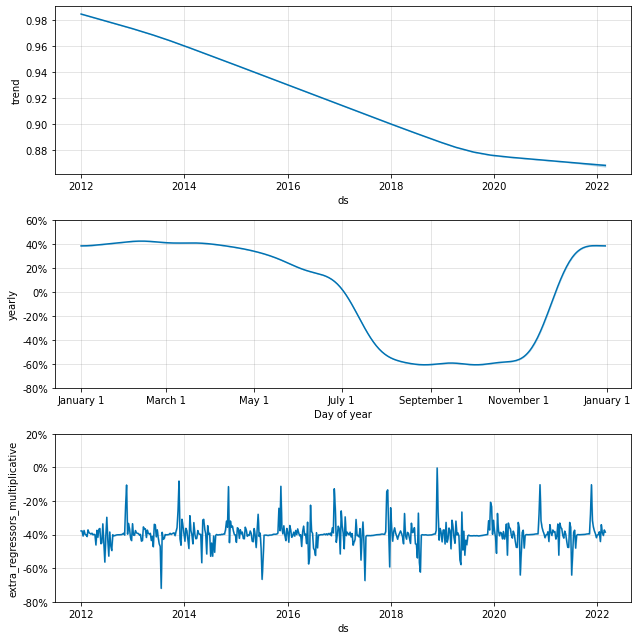

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.125156
std       0.084005
min       0.002164
25%       0.048659
50%       0.132205
75%       0.182302
max       0.264644
Name: rmse, dtype: float64


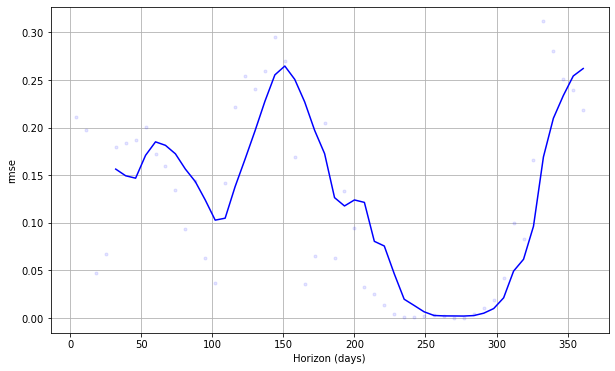

In [ ]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('sst', standardize=False)
basic.add_regressor('ice-dt', standardize=True, mode='multiplicative')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt

# copy ice-dt from last year for first attemp
week_future['ice-dt'] = weekly['ice-dt'].copy()
guess_dt = weekly['ice-dt'].iloc[-52::].values.copy()
week_future['ice-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


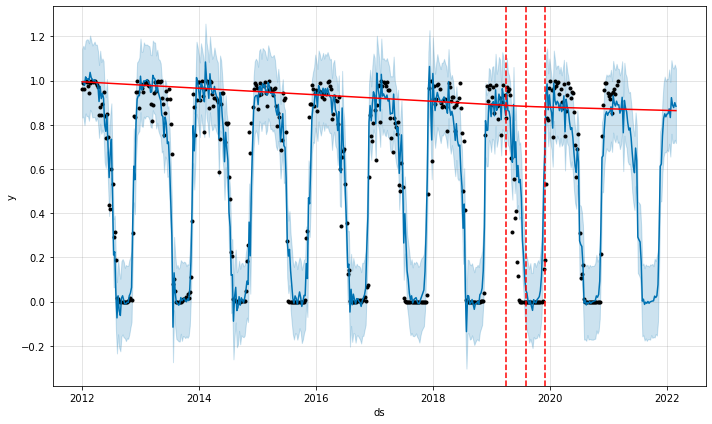

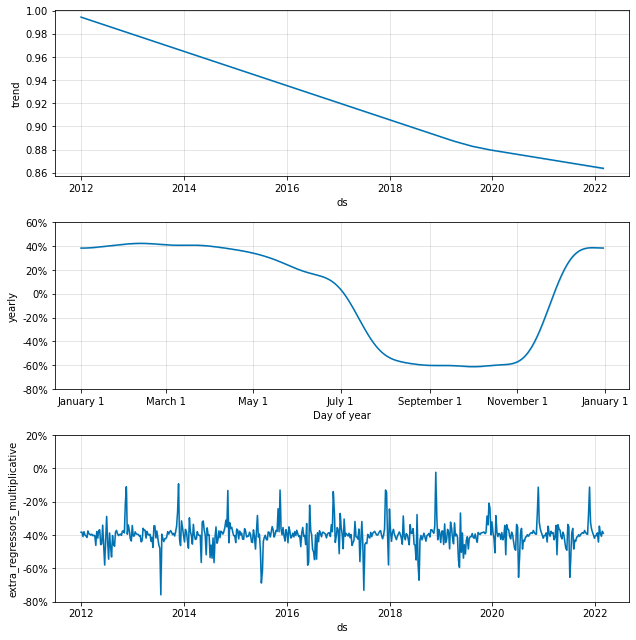

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.125233
std       0.083078
min       0.006199
25%       0.050475
50%       0.130243
75%       0.180868
max       0.263915
Name: rmse, dtype: float64


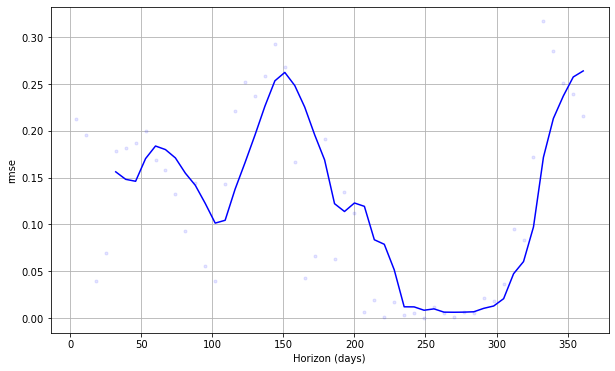

In [ ]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('sst', standardize=False)
basic.add_regressor('air-dt', standardize=False, mode='multiplicative')
basic.add_regressor('ice-dt', standardize=True, mode='multiplicative')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt

# copy ice-dt from last year for first attemp
week_future['ice-dt'] = weekly['ice-dt'].copy()
guess_dt = weekly['ice-dt'].iloc[-52::].values.copy()
week_future['ice-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


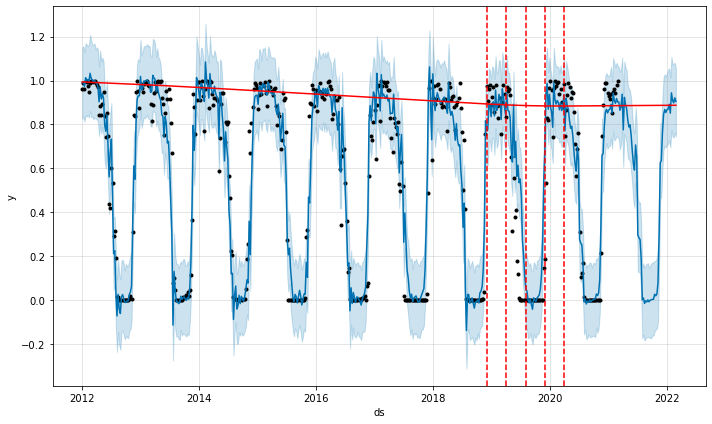

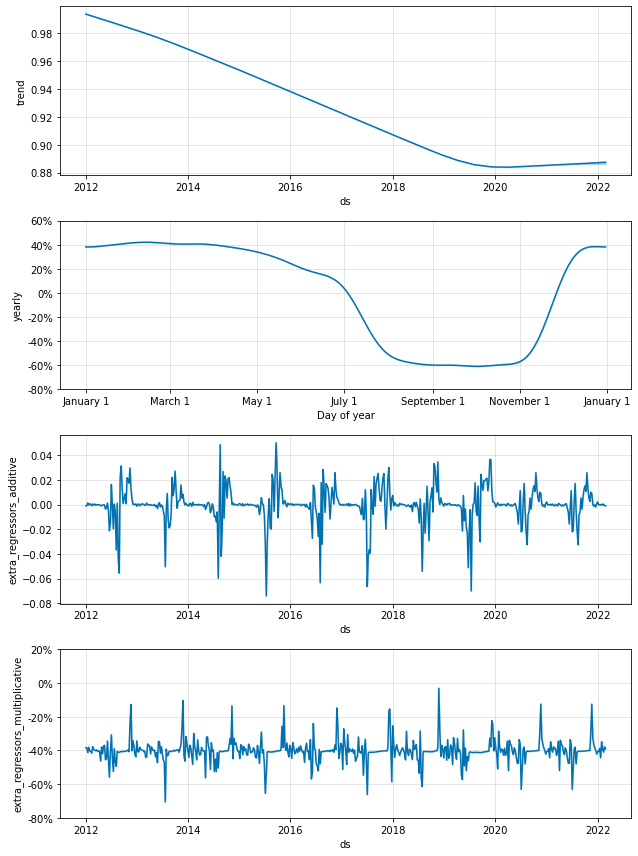

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    48.000000
mean      0.123695
std       0.081183
min       0.006362
25%       0.051597
50%       0.127522
75%       0.176781
max       0.260802
Name: rmse, dtype: float64


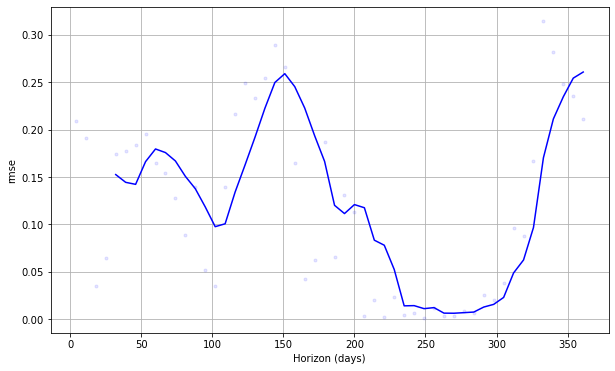

In [ ]:
# Same model as Model 2C
basic = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=None,
    seasonality_mode='multiplicative',
    changepoint_range=0.9
)
basic.add_regressor('sst', standardize=False)
basic.add_regressor('air-dt', standardize=False, mode='additive')
basic.add_regressor('ice-dt', standardize=True, mode='multiplicative')
basic.fit(weekly)

# Add air for future from last year available.
# - this is bogus
week_future = basic.make_future_dataframe(52, freq='W')
#week_future['cap'] = 1
#week_future['floor'] = 0

# copy temp from last year for first attempt of adding
week_future['sst'] = weekly['sst'].copy()
guess_temp = weekly['sst'].iloc[-52::].values.copy()
week_future['sst'].iloc[-52::] = guess_temp

# copy ait-dt from last year for first attemp
week_future['air-dt'] = weekly['air-dt'].copy()
guess_dt = weekly['air-dt'].iloc[-52::].values.copy()
week_future['air-dt'].iloc[-52::] = guess_dt

# copy ice-dt from last year for first attemp
week_future['ice-dt'] = weekly['ice-dt'].copy()
guess_dt = weekly['ice-dt'].iloc[-52::].values.copy()
week_future['ice-dt'].iloc[-52::] = guess_dt


forecast = basic.predict(week_future)
fig1 = basic.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), basic, forecast)
fig2 = basic.plot_components(forecast)

plt.show()
cutoffs = pd.to_datetime([
    '2020-01-01'
])
df_cv = diagnostics.cross_validation(
    basic,
    cutoffs=cutoffs,
    horizon='365 days'
)
plt.show()

plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")